In [1]:
# @title General Setup
from google.colab import drive
drive.mount('/content/drive')

!pip install numpy==1.22.3
!pip install datasets
!pip install shap
!pip install transformers

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from google.colab import widgets

from collections import Counter
import re
import numpy as np
import pandas as pd
import math
import torch
import gc
import matplotlib.pyplot as plt
from torch import nn


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.12.3 requires numpy>=1.23.0, but you have numpy 1.22.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.5 MB/s eta 0:00:00


# Pre-Process
Extracts data from MIMIC-3 and saves a final dataframe with tabular, text and targets for each patient admission.

## Setup

In [ ]:
# @title Vars
pred_gap = 6            # minimal gap between prediction and target (hours)
min_los = 24             # minimal length of stay (hours)
min_target_onset = 2*24  # minimal time of target since admission (hours)

In [ ]:
# @title Load MIMIC 3
project = 'taumlhc'
client = bigquery.Client(project=project)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Notes
Extracts two textual features - 'nursing_notes' contains the latest nursing notes and all_notes contains all nursing and physician notes.

In [ ]:
# @title Extract Notes

def load_notes():
    notes_query = """
    SELECT noteevents.text, noteevents.hadm_id, noteevents.charttime,
           noteevents.category, noteevents.subject_id, admissions.admittime
    FROM `physionet-data.mimiciii_notes.noteevents` noteevents
    INNER JOIN `physionet-data.mimiciii_clinical.patients` patients
        ON noteevents.subject_id = patients.subject_id
    INNER JOIN `physionet-data.mimiciii_clinical.admissions` admissions
        ON noteevents.hadm_id = admissions.hadm_id
    ORDER BY noteevents.subject_id, noteevents.hadm_id, noteevents.charttime;
    """

    notes = client.query(notes_query).result().to_dataframe().rename(str.lower, axis='columns')

    initial_cohort = pd.read_csv('/content/drive/MyDrive/ProjectMLHC/meta_data/initial_cohort.csv')
    notes = pd.merge(notes, initial_cohort, how='inner', on='subject_id')

    return notes

gc.collect()
notes = load_notes()
gc.collect()


In [ ]:
# @title Exclusion

# Filter rows where charttime is more than 42 hours after admittime
mask = (notes['charttime'] - notes['admittime']) <= pd.Timedelta(hours=42)
filtered_notes = notes[mask][['hadm_id','category','text', 'charttime']]

del notes
gc.collect()

0

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('GanjinZero/biobart-base')


In [ ]:
# # @title Unique categories
# categories = filtered_notes['category'].unique()
# plt.figure(figsize=(10, 3 * len(categories)))

# for i, category in enumerate(categories, 1):
#     plt.subplot(len(categories), 1, i)

#     texts = filtered_notes[filtered_notes['category'] == category]['text'].tolist()

#     # Tokenize the texts in a batch ##### I'LL FIX THE TOKENIZE WE CAN IGNORE THAT NOW
#     encodings = tokenizer.batch_encode_plus(texts, truncation=False, padding=False
#                                       )
#     lengths = [len(encoding) for encoding in encodings['input_ids']]
#     del encodings
#     gc.collect()

#     plt.hist(lengths, bins=50, edgecolor='black')
#     plt.title(f"Distribution of Token Counts for {category}")
#     plt.xlabel("Number of Tokens")
#     plt.ylabel("Frequency")
#     plt.grid(axis='y')
#     plt.tight_layout(pad=2.0)

# plt.show()



### Only Nursing

In [ ]:
# Get only the two latest nursings types, and for every patient with two of them, concat
first_notes = filtered_notes.loc[filtered_notes.groupby(['hadm_id', 'category'])['charttime'].idxmax()]
first_notes = first_notes[first_notes['category'].isin(['Nursing', 'Nursing/other'])]

# Concat
first_notes = first_notes.groupby(['hadm_id'])['text'].apply(' '.join).reset_index()
first_notes.columns = ['hadm_id','first_notes']


In [ ]:
# # @title nursing_notes Distribution
# fig, ax = plt.subplots(figsize=(5, 2.5))  # 50% of default (10, 5)

# # Tokenize
# encodings = tokenizer.batch_encode_plus(nursing_notes['nursing_notes'].to_list(), truncation=False, padding=False)
# lengths = [len(encoding) for encoding in encodings['input_ids']]

# # Convert lengths to pandas Series for histogram
# pd.Series(lengths).hist(bins=50, edgecolor='black', ax=ax)
# ax.set_title("Distribution of nursing_notes tokenized length")
# ax.set_xlabel("Length")
# ax.set_ylabel("Frequency")
# plt.show()

# del encodings
# del lengths
# gc.collect()

### All notes

In [ ]:
# Keep only the 3 relevant categories
all_notes = filtered_notes[filtered_notes['category'].isin(['Nursing', 'Nursing/other', 'Physician'])]

# Concat
all_notes = all_notes.groupby(['hadm_id'])['text'].apply(' '.join).reset_index()
all_notes.columns = ['hadm_id', 'all_notes']


In [ ]:
# # @title all_notes Distribution
# fig, ax = plt.subplots(figsize=(5, 2.5))  # 50% of default (10, 5)

# # Tokenize
# batch_size = 1000
# all_encodings = []

# for i in range(0, len(all_notes['all_notes']), batch_size):
#     batch = all_notes['all_notes'].iloc[i:i+batch_size].to_list()
#     encodings = tokenizer.batch_encode_plus(batch, truncation=False, padding=False)['input_ids']
#     all_encodings.extend(encodings)

# lengths = [len(encoding) for encoding in all_encodings]

# # Convert lengths to pandas Series for histogram
# pd.Series(lengths).hist(bins=50, edgecolor='black', ax=ax)
# ax.set_title("Distribution of Description Lengths")
# ax.set_xlabel("Length")
# ax.set_ylabel("Frequency")
# plt.show()

# del all_encodings
# del lengths
# del encodings
# gc.collect()

## Tabular - Demographic, Vital and Lab

### Demograhic

In [ ]:
def load_hosps():
  hospquery = \
  """
  SELECT admissions.subject_id, admissions.hadm_id
  , admissions.admittime, admissions.dischtime
  , admissions.ethnicity
  , patients.gender, patients.dob, patients.dod
  FROM `physionet-data.mimiciii_clinical.admissions` admissions
  INNER JOIN `physionet-data.mimiciii_clinical.patients` patients
      ON admissions.subject_id = patients.subject_id
  WHERE admissions.has_chartevents_data = 1
  ORDER BY admissions.subject_id, admissions.hadm_id, admissions.admittime;
  """
  hosps = client.query(hospquery).result().to_dataframe().rename(str.lower, axis='columns')

  initial_cohort = pd.read_csv('/content/drive/MyDrive/ProjectMLHC/meta_data/initial_cohort.csv')
  hosps = pd.merge(hosps,initial_cohort,how='inner', on='subject_id')
  return hosps

hosps = load_hosps()

In [ ]:
# @title Feature Extraction

# Generate feature columns for los, age and mortality
def age(admittime, dob):
    if admittime < dob:
      return 0
    return admittime.year - dob.year - ((admittime.month, admittime.day) < (dob.month, dob.day))

hosps['age'] = hosps.apply(lambda row: age(row['admittime'], row['dob']), axis=1)
hosps['los_hosp_hr'] = (hosps.dischtime - hosps.admittime).astype('timedelta64[h]')
hosps['mort'] = np.where(~np.isnat(hosps.dod),1,0)


# Ethnicity - one hot encoding
hosps.ethnicity = hosps.ethnicity.str.lower()
hosps.loc[(hosps.ethnicity.str.contains('^white')),'ethnicity'] = 'white'
hosps.loc[(hosps.ethnicity.str.contains('^black')),'ethnicity'] = 'black'
hosps.loc[(hosps.ethnicity.str.contains('^hisp')) | (hosps.ethnicity.str.contains('^latin')),'ethnicity'] = 'hispanic'
hosps.loc[(hosps.ethnicity.str.contains('^asia')),'ethnicity'] = 'asian'
hosps.loc[~(hosps.ethnicity.str.contains('|'.join(['white', 'black', 'hispanic', 'asian']))),'ethnicity'] = 'other'
hosps = pd.concat([hosps, pd.get_dummies(hosps['ethnicity'], prefix='eth')], axis = 1)

# Gender to binary
hosps['gender'] = np.where(hosps['gender']=="M", 1, 0)

In [ ]:
# @title Exclusion

# First admission for each patient
hosps = hosps.sort_values('admittime').groupby('subject_id').first().reset_index()
print(f"1. Include only first admissions: N={hosps.shape[0]}")

# Exclude patients with less than min_los hours.
hosps = hosps[(hosps['dischtime'] - hosps['admittime']).dt.total_seconds()/60/60 >min_los]
print(f"3. Include only patients who admitted for at least {min_los} hours: N={hosps.shape[0]}")




#hosps = hosps[hosps.age.between(17,300,inclusive='neither')]
#print(f"2. Exclusion by ages: N={hosps.shape[0]}")


# <implement here> Exclude by death time
hosps['time_diff'] = (hosps['dod'] - hosps['admittime']).dt.total_seconds() /60/60 # in hours
hosps = hosps[~(hosps['time_diff'] <=min_target_onset)]
hosps = hosps.drop(['time_diff'], axis='columns')

print(f"4. Exclude patients who died within {min_target_onset}-hours of admission: N={hosps.shape[0]}")

1. Include only first admissions: N=32513
3. Include only patients who admitted for at least 24 hours: N=31324
4. Exclude patients who died within 48-hours of admission: N=30897


### Lab

In [ ]:
# @title Query DB
labquery = \
"""--sql
  SELECT labevents.subject_id ,labevents.hadm_id ,labevents.charttime
  , labevents.itemid, labevents.valuenum
  , admissions.admittime
  FROM `physionet-data.mimiciii_clinical.labevents` labevents
    INNER JOIN `physionet-data.mimiciii_clinical.admissions` admissions
    ON labevents.subject_id = admissions.subject_id
    AND labevents.hadm_id = admissions.hadm_id
    AND labevents.charttime >=(admissions.admittime)
    AND itemid in UNNEST(@itemids)
"""
lavbevent_meatdata = pd.read_csv('/content/drive/MyDrive/ProjectMLHC/meta_data/labs_metadata.csv')
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("itemids", "INTEGER", lavbevent_meatdata['itemid'].tolist()),
    ]
)
labs = client.query(labquery, job_config=job_config).result().to_dataframe().rename(str.lower, axis='columns')

initial_cohort = pd.read_csv('/content/drive/MyDrive/ProjectMLHC/meta_data/initial_cohort.csv')
labs = pd.merge(labs,initial_cohort,how='inner', on='subject_id')


In [ ]:
# @title Filter Invalid Mesurments
labs = labs[labs['hadm_id'].isin(hosps['hadm_id'])]
labs = pd.merge(labs,lavbevent_meatdata,on='itemid')
labs = labs[labs['valuenum'].between(labs['min'],labs['max'],  inclusive='both')]
print(labs)

         subject_id  hadm_id           charttime  itemid  valuenum  \
0               357   174486 2197-12-07 01:00:00   51221      34.8   
1               357   174486 2198-01-02 05:10:00   51221      28.3   
2               357   174486 2197-12-10 20:04:00   51221      29.8   
3               357   174486 2197-12-20 03:00:00   51221      30.4   
4               357   174486 2197-12-23 22:48:00   51221      27.4   
...             ...      ...                 ...     ...       ...   
5387569       11269   163226 2196-05-03 05:40:00   51300       1.3   
5387570       49853   179842 2138-09-27 04:10:00   51300       3.4   
5387571       10233   109425 2139-08-02 04:00:00   51300      14.7   
5387572       22167   197295 2163-11-11 20:48:00   51300       7.7   
5387573        9089   179408 2120-11-11 10:00:00   51300      10.6   

                  admittime measurement name feature name   min  max units  \
0       2197-12-06 07:13:00       HEMATOCRIT   HEMATOCRIT  10.0   80     %   
1  

In [ ]:
# @title Exclusion
labs = labs[labs['charttime'] - labs['admittime'] <= pd.Timedelta(hours=42)]
labs = labs[['hadm_id', 'charttime', 'feature name', 'valuenum']]

In [ ]:
# @title Pivot & Find First Lab Tests

# Groupby admission id and feature name, and keep only the row with the earliest charttime
temp = labs.sort_values(['charttime'], ascending=True).groupby(['hadm_id','feature name']).first().reset_index()
# Pivot the dataframe
final_labs = temp.pivot(index='hadm_id', columns= 'feature name', values='valuenum').reset_index()
final_labs.columns = final_labs.columns.str.lower()

final_labs.head()

del temp

In [ ]:
final_labs

feature name,hadm_id,albumin,anion gap,bicarbonate,bilirubin,bun,chloride,creatinine,glucose,hematocrit,...,inr,lactate,magnesium,phosphate,platelet,potassium,pt,ptt,sodium,wbc
0,100003,2.3,10.0,16.0,5.5,49.0,112.0,1.2,56.0,21.3,...,1.6,1.1,1.9,3.8,148.0,5.0,17.5,35.8,133.0,13.4
1,100006,NaN,8.0,24.0,NaN,16.0,103.0,0.6,129.0,30.6,...,1.3,NaN,1.6,4.3,204.0,3.7,14.2,29.8,131.0,13.6
2,100007,NaN,12.0,25.0,NaN,12.0,107.0,0.6,115.0,37.1,...,NaN,NaN,1.6,4.2,259.0,4.1,NaN,NaN,140.0,12.3
3,100009,4.3,13.0,25.0,0.3,19.0,103.0,0.8,263.0,40.7,...,1.1,1.1,1.9,NaN,167.0,4.2,13.2,49.1,137.0,7.8
4,100010,NaN,10.0,23.0,NaN,10.0,106.0,0.9,124.0,27.0,...,NaN,0.6,1.3,NaN,310.0,3.4,NaN,NaN,138.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30002,199992,NaN,12.0,26.0,0.2,13.0,114.0,0.7,83.0,31.9,...,0.9,NaN,2.1,2.1,162.0,3.7,11.3,42.1,148.0,5.1
30003,199993,3.3,14.0,26.0,0.8,11.0,103.0,0.9,94.0,34.0,...,1.1,NaN,2.1,3.2,346.0,4.5,13.1,34.5,138.0,7.3
30004,199995,NaN,15.0,26.0,0.1,15.0,101.0,0.7,90.0,27.3,...,1.1,NaN,2.0,4.7,454.0,3.8,12.9,30.5,138.0,10.7
30005,199998,4.2,15.0,27.0,0.7,16.0,103.0,0.9,109.0,37.0,...,1.0,1.1,1.7,3.6,241.0,4.3,11.7,29.0,141.0,9.6


### Vital

In [ ]:
# @title Extract
vitquery = \
"""--sql
  SELECT chartevents.subject_id ,chartevents.hadm_id ,chartevents.charttime
  , chartevents.itemid, chartevents.valuenum
  , admissions.admittime
  FROM `physionet-data.mimiciii_clinical.chartevents` chartevents
  INNER JOIN `physionet-data.mimiciii_clinical.admissions` admissions
  ON chartevents.subject_id = admissions.subject_id
  AND chartevents.hadm_id = admissions.hadm_id
  AND chartevents.charttime between
  (admissions.admittime)
  AND (admissions.admittime + interval '48' hour)
  AND itemid in UNNEST(@itemids)
  -- exclude rows marked as error
  AND chartevents.error IS DISTINCT FROM 1
"""
vital_meatdata = pd.read_csv('/content/drive/MyDrive/ProjectMLHC/meta_data/vital_metadata.csv')
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("itemids", "INTEGER", vital_meatdata['itemid'].tolist()),
    ]
)
vits = client.query(vitquery, job_config=job_config).result().to_dataframe().rename(str.lower, axis='columns')

initial_cohort = pd.read_csv('/content/drive/MyDrive/ProjectMLHC/meta_data/initial_cohort.csv')
vits = pd.merge(vits,initial_cohort,how='inner', on='subject_id')


In [ ]:
# @title Filter Invalid Measurement

# Merge the data with the vital_meatdata
merged = vits.merge(vital_meatdata, on='itemid')
# Lowercase
merged['feature name'] = merged['feature name'].str.lower()

# Keep only values in range
filtered = merged[(merged['max'] >= merged['valuenum']) & (merged['valuenum'] >= merged['min'])]

# Drop unrelevant columns
vits = filtered.drop(['min','max', 'itemid'], axis='columns')

vits.head()

,subject_id,hadm_id,charttime,valuenum,admittime,measurement name,feature name,units
0,24700,158359,2136-11-20 10:30:00,45.0,2136-11-20 06:53:00,BloodGlucose,glucose,mg/dL
1,25129,146865,2169-09-06 03:45:00,97.0,2169-09-06 02:20:00,BloodGlucose,glucose,mg/dL
2,28465,135377,2168-01-29 03:45:00,90.0,2168-01-27 07:11:00,BloodGlucose,glucose,mg/dL
3,28465,135377,2168-01-27 09:15:00,62.0,2168-01-27 07:11:00,BloodGlucose,glucose,mg/dL
4,20772,137635,2112-09-11 22:30:00,68.0,2112-09-11 21:59:00,BloodGlucose,glucose,mg/dL


In [ ]:
# @title Units Conversion

def fahrenheit_to_celsius(f):
    return (f - 32) * 5 / 9
# Locate the rows with 'tempF' feature
tempF_rows = vits['feature name'] == 'tempf'

# Convert the 'valuenum' for 'tempF' rows to Celsius
vits.loc[tempF_rows, 'valuenum'] = vits.loc[tempF_rows, 'valuenum'].apply(fahrenheit_to_celsius)

# Change the feature name from 'tempF' to 'tempC'
vits.loc[tempF_rows, 'feature name'] = 'tempc'

In [ ]:
# @title Exclusion
vits = vits[vits['charttime'] - vits['admittime'] <= pd.Timedelta(hours=42)]
vits = vits[['hadm_id', 'charttime', 'feature name', 'valuenum']]

In [ ]:
# @title Calculate Measurement Statistics in First 42 Hours

# Group by hadm_id and feature_name (except for weight), and calculate min, max, and mean
vit_without_weights = vits[vits['feature name'] != 'weight']
result = vit_without_weights.groupby(['hadm_id', 'feature name']).agg({'valuenum': ['min', 'max', 'mean']}).reset_index()
print(result)
# Create separate pivot tables for min, max, and median
pivot_min = result.pivot(index='hadm_id', columns='feature name', values=('valuenum', 'min')).add_suffix('_min').reset_index()
pivot_max = result.pivot(index='hadm_id', columns='feature name', values=('valuenum', 'max')).add_suffix('_max').reset_index()
pivot_median = result.pivot(index='hadm_id', columns='feature name', values=('valuenum', 'mean')).add_suffix('_mean').reset_index()

# Merge the three pivot tables into a single table on hadm_id
result = pivot_min.merge(pivot_max, on='hadm_id').merge(pivot_median, on='hadm_id')
result.columns = result.columns.str.lower()
# Re-arrange
features = ['heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'spo2', 'glucose', 'tempc']
column_order = ['hadm_id'] + [f'{feature}_{stat}' for feature in features for stat in ['min', 'max', 'mean']]
temp_vits1 = result[column_order]



       hadm_id feature name    valuenum                        
                                    min         max        mean
0       100003       diasbp   36.000000   91.000000   59.836735
1       100003      glucose   56.000000  135.000000   93.000000
2       100003    heartrate   69.000000  104.000000   80.980769
3       100003       meanbp   47.000000   97.000000   73.163265
4       100003     resprate   11.000000   23.000000   15.807692
...        ...          ...         ...         ...         ...
237153  199999       meanbp   73.000000   76.000000   74.500000
237154  199999     resprate   15.000000   23.000000   20.000000
237155  199999         spo2   94.000000   95.000000   94.666667
237156  199999        sysbp  128.000000  130.000000  129.000000
237157  199999        tempc   36.555556   36.555556   36.555556

[237158 rows x 5 columns]


In [ ]:
# Keep only the first weight of patient
temp_vits2 = vits[vits['feature name'] == 'weight'].copy()

# Groupby admission id and feature name, and keep only the row with the earliest charttime
temp_vits2 = temp_vits2.sort_values(['charttime'],ascending= True).groupby(['hadm_id', 'feature name']).first().reset_index()
temp_vits2 = temp_vits2.filter(['subject_id','hadm_id', 'valuenum']).rename(columns={'valuenum': 'weight'})


final_vits = temp_vits1.merge(temp_vits2, on=['hadm_id'], how='outer')

del vits
del temp_vits2, temp_vits1

In [ ]:
final_vits

,hadm_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,...,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean,tempc_min,tempc_max,tempc_mean,weight
0,100003,69.0,104.0,80.980769,77.0,149.0,115.346939,36.0,91.0,59.836735,...,86.0,100.0,98.229167,56.0,135.0,93.000000,35.500000,36.777778,36.350000,85.300000
1,100006,86.0,127.0,108.954545,113.0,161.0,135.547619,50.0,101.0,76.857143,...,79.0,100.0,97.577778,129.0,183.0,153.444444,36.111111,37.111113,36.438889,57.000000
2,100007,55.0,93.0,74.139535,108.0,164.0,138.906977,47.0,76.0,61.046512,...,96.0,100.0,99.409091,102.0,179.0,132.777778,35.388887,37.722223,36.716050,55.099998
3,100009,70.0,92.0,79.409091,98.0,132.0,116.000000,45.0,60.0,53.130435,...,91.0,100.0,97.285714,98.0,224.0,144.888889,NaN,NaN,NaN,115.000000
4,100010,56.0,109.0,79.571429,45.0,159.0,99.071429,28.0,143.0,54.857143,...,93.0,100.0,99.178571,83.0,133.0,105.333333,36.166667,37.888889,36.930556,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34270,182650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.000000
34271,189819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.800003
34272,196133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.699997
34273,198555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.199997


### Medication
Extracts two features from the medication table - the amount of medications and the amount of unique medications taken.

In [ ]:
def load_meds():
  med_query = \
  """
  SELECT admissions.hadm_id, admissions.subject_id, admissions.admittime, drug, startdate, enddate
  FROM `physionet-data.mimiciii_clinical.prescriptions` prescriptions
  INNER JOIN `physionet-data.mimiciii_clinical.admissions` admissions
      ON prescriptions.hadm_id = admissions.hadm_id
  ORDER BY admissions.subject_id, admissions.hadm_id, admissions.admittime;
  """

  meds = client.query(med_query).result().to_dataframe().rename(str.lower, axis='columns')

  initial_cohort = pd.read_csv('/content/drive/MyDrive/ProjectMLHC/meta_data/initial_cohort.csv')
  meds = pd.merge(meds, initial_cohort, how='inner', on='subject_id')
  return meds

meds = load_meds()


In [ ]:
# @title Exclusion
print(meds.shape)
meds = meds[meds['startdate'] - meds['admittime'] <= pd.Timedelta(hours=42)]
meds = meds[['subject_id','hadm_id', 'drug']]

(2910964, 6)


In [ ]:
meds_count = meds.groupby('hadm_id').size().rename('meds_count', inplace=True)
meds_unique_count = meds.groupby('hadm_id')['drug'].nunique().rename('meds_unique_count', inplace=True)


final_meds = pd.merge(meds_unique_count, meds_count, on='hadm_id')
gc.collect()

0

In [ ]:
final_meds

,meds_unique_count,meds_count
hadm_id,,
100003,20,26
100006,17,24
100007,17,29
100009,45,69
100010,24,37
...,...,...
199992,27,35
199993,11,15
199995,8,8


## Final Preprocessing
Combines demographic, vital and lab dfs and adds prediction objectives

In [ ]:
# @title Combine

# Merge tabular
combined_df = pd.merge(final_vits, final_labs, on='hadm_id')
combined_df = pd.merge(hosps, combined_df, on='hadm_id', how='left')
combined_df = pd.merge(combined_df,final_meds, on='hadm_id', how='left')

# Merge text
combined_df = combined_df.merge(first_notes, how='left', on='hadm_id')
del first_notes
gc.collect()
combined_df = combined_df.merge(all_notes, how='left', on='hadm_id')
del all_notes
gc.collect()

del hosps
del final_vits
del final_labs
del final_meds
gc.collect()

combined_df

,subject_id,hadm_id,admittime,dischtime,ethnicity,gender,dob,dod,age,los_hosp_hr,...,platelet,potassium,pt,ptt,sodium,wbc,meds_unique_count,meds_count,first_notes,all_notes
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,asian,1,2138-07-17,NaT,0,92.0,...,5.0,NaN,NaN,NaN,NaN,22.0,4.0,4.0,Nursing Transfer note\n\n\nPt admitted to NICU...,Neonatology Attending Triage Note\n\nBaby [**N...
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,white,1,2025-04-11,2102-06-14,76,258.0,...,190.0,4.4,15.7,58.3,138.0,11.3,NaN,NaN,Micu Nursing Progress Note:\n\nNeuro: Remains ...,Micu Progress Nursing Note:\n\nPatient arrived...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,white,0,2143-05-12,NaT,47,186.0,...,201.0,3.3,12.8,33.2,141.0,9.7,22.0,31.0,"[**2187**]: Pt c/o cough, non-productive, dry....",[**2191-3-16**] 0500\nGeneral: Pt in to EW fro...
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,asian,1,2103-02-02,NaT,0,55.0,...,309.0,NaN,NaN,NaN,NaN,13.9,NaN,NaN,NICU Nursing Septic Workup Note\n[**Name8 (MD)...,NNP Triage Note\n\nBB [**Known lastname 6**] d...
4,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,white,0,2121-05-23,NaT,0,92.0,...,223.0,NaN,NaN,NaN,NaN,22.8,NaN,NaN,NPN Septic evaluation\nInfant was brought from...,Neonatology\nPatient is now 36 h old term infa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30892,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,white,1,2127-04-08,NaT,53,398.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23.0,31.0,NaN,NaN
30893,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,white,1,2137-04-07,NaT,47,291.0,...,NaN,NaN,NaN,NaN,NaN,NaN,15.0,16.0,NaN,NaN
30894,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,white,0,2078-10-17,NaT,65,71.0,...,105.0,4.9,NaN,NaN,136.0,17.1,23.0,28.0,NaN,NaN
30895,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,white,0,2058-05-29,2147-09-29,88,77.0,...,189.0,3.5,19.7,35.5,132.0,8.2,26.0,45.0,NaN,NaN


In [ ]:
# @title Keep rows with prediction objectives
bool1 = (combined_df['dischtime'] - combined_df['admittime']) >= pd.Timedelta(hours=48)
bool2 = (combined_df['dod'] - combined_df['admittime']) >= pd.Timedelta(hours=48)

# Either died or discharged after 48 hours
combined_df = combined_df[bool1 | bool2]

combined_df = combined_df[(combined_df['age'] > 18 & (combined_df['age'] < 90))]

In [ ]:
original_hosps = load_hosps()

# Get the second admission for each patient
original_hosps['rank'] = original_hosps.groupby('subject_id')['admittime'].rank(method="first")
second_admissions = original_hosps[original_hosps['rank'] == 2].reset_index(drop=True)
del original_hosps['rank']


second_admissions = second_admissions[['subject_id', 'admittime']]
second_admissions.rename(columns={'admittime':'second_admittime'})
print(second_admissions)

      subject_id           admittime
0             21 2135-01-30 20:50:00
1             36 2131-05-12 19:49:00
2             85 2167-07-25 18:49:00
3             94 2176-09-02 14:22:00
4            103 2144-08-30 23:09:00
...          ...                 ...
4606       99822 2197-06-16 03:01:00
4607       99883 2132-09-15 00:36:00
4608       99897 2182-07-03 19:50:00
4609       99923 2201-05-15 13:12:00
4610       99982 2157-01-05 17:27:00

[4611 rows x 2 columns]


In [ ]:
# If readmitted within 30 days after discharge
combined_df = pd.merge(combined_df, second_admissions, on='subject_id', how='left', suffixes=('', '_second'))
print(combined_df.columns)
combined_df['readmission_target'] = (combined_df['admittime_second'] - combined_df['dischtime'] <= pd.Timedelta(days=30))

# If died during hospitalization or within 30 days after discharge
mask1 = (combined_df['dod'] - combined_df['dischtime'] <= pd.Timedelta(days=30))
mask2 = (combined_df['dod'] < combined_df['dischtime'])
combined_df['mort_target'] = mask1 | mask2

# If hospitalization longer than 7 days
combined_df['prolonged_stay_target'] = combined_df['los_hosp_hr'] >= 7*24

combined_df[['readmission_target', 'mort_target', 'prolonged_stay_target']] = combined_df[['readmission_target', 'mort_target', 'prolonged_stay_target']].astype(int)


Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'ethnicity',
       'gender', 'dob', 'dod', 'age', 'los_hosp_hr', 'mort', 'eth_asian',
       'eth_black', 'eth_hispanic', 'eth_other', 'eth_white', 'heartrate_min',
       'heartrate_max', 'heartrate_mean', 'sysbp_min', 'sysbp_max',
       'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean', 'meanbp_min',
       'meanbp_max', 'meanbp_mean', 'resprate_min', 'resprate_max',
       'resprate_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min',
       'glucose_max', 'glucose_mean', 'tempc_min', 'tempc_max', 'tempc_mean',
       'weight', 'albumin', 'anion gap', 'bicarbonate', 'bilirubin', 'bun',
       'chloride', 'creatinine', 'glucose', 'hematocrit', 'hemoglobin', 'inr',
       'lactate', 'magnesium', 'phosphate', 'platelet', 'potassium', 'pt',
       'ptt', 'sodium', 'wbc', 'meds_unique_count', 'meds_count',
       'first_notes', 'all_notes', 'admittime_second'],
      dtype='object')


In [ ]:
final_df = combined_df.drop(['hadm_id', 'mort', 'admittime','dischtime', 'subject_id','admittime_second','dod','dob', 'ethnicity', 'los_hosp_hr'], axis='columns')
# Edited pipeline for BART
final_df.to_csv('/content/drive/MyDrive/ProjectMLHC/data/final_df_bart.csv', index=False)



# Impute and make data ready
Helper Functions to use in order to create train-val-test data from the final patients dataframe.

In [2]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (f1_score, accuracy_score, precision_score,
                             precision_recall_curve, recall_score, roc_curve,
                             PrecisionRecallDisplay, ConfusionMatrixDisplay,
                             confusion_matrix, auc, RocCurveDisplay)
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import shap
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, f1_score, roc_curve, recall_score, precision_recall_curve, auc
from sklearn.metrics import precision_recall_fscore_support as score
from numpy import interp
from sklearn.utils import resample
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.base import clone


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
tabular_features =       ['gender', 'age',
       'eth_asian', 'eth_black', 'eth_hispanic', 'eth_other', 'eth_white',
       'diasbp_max', 'glucose_max', 'heartrate_max', 'meanbp_max',
       'resprate_max', 'spo2_max', 'sysbp_max', 'tempc_max', 'diasbp_min',
       'glucose_min', 'heartrate_min', 'meanbp_min', 'resprate_min',
       'spo2_min', 'sysbp_min', 'tempc_min', 'diasbp_mean', 'glucose_mean',
       'heartrate_mean', 'meanbp_mean', 'resprate_mean', 'spo2_mean',
       'sysbp_mean', 'tempc_mean', 'albumin', 'anion gap', 'bicarbonate',
       'bilirubin', 'bun', 'chloride', 'creatinine', 'glucose', 'hematocrit',
       'hemoglobin', 'inr', 'lactate', 'magnesium', 'phosphate', 'platelet',
       'potassium', 'pt', 'ptt', 'sodium', 'wbc', 'weight', 'meds_count', 'meds_unique_count']


In [4]:
# @title Split to final dataset

# Helper function for models to generate the required data for training and testing.
def get_data_splits(df, include=['first_notes', 'all_notes', 'tabular'],
        targets = ['readmission_target', 'mort_target', 'prolonged_stay_target'], test_size=0.2, fill_missing_notes=True):

    features = []
    features += tabular_features

    if 'first_notes' in include:
        features.append('first_notes')
    if 'all_notes' in include:
        features.append('all_notes')

    data = df[features + targets]
    text_cols =  [x for x in include if x != "tabular"]

    if fill_missing_notes:
      data.loc[:, text_cols] = data.loc[:,text_cols].fillna("Unknown")
    else:
      data.dropna(subset=text_cols, how='any', inplace=True)

    train_data, test_data = train_test_split(data, test_size=test_size, random_state=0)


    if 'tabular' in include:
        # Construct transformers and pipelines
        tabular_transformer = make_pipeline(
            KNNImputer(),
            MinMaxScaler()
        )
        preprocessor = make_column_transformer(
            (tabular_transformer, tabular_features),
            ('passthrough', text_cols+ targets),
        )
        train_data = pd.DataFrame(preprocessor.fit_transform(train_data), columns=tabular_features + text_cols + targets)
        test_data = pd.DataFrame(preprocessor.transform(test_data), columns=tabular_features + text_cols + targets)

    train_data[tabular_features] = train_data[tabular_features].astype(float)
    test_data[tabular_features] = test_data[tabular_features].astype(float)
    train_targets = train_data[targets].copy()
    test_targets = test_data[targets].copy()

    train_data = train_data.drop(columns=targets)
    test_data = test_data.drop(columns=targets)

    return train_data,train_targets.astype(int),test_data,test_targets.astype(int)


In [5]:
# @title For DAN and BART
# Helper function for torch models to generate datasets-type train and test data.
def get_tokenized_datasets(note_col, target_col, tokenize_function,fill_missing_notes=True):
    final_df = pd.read_csv('/content/drive/MyDrive/ProjectMLHC/data/final_df_bart.csv')
    X_train, y_train, X_test, y_test = get_data_splits(final_df, include=['tabular',note_col], fill_missing_notes=False)
    print(X_train)
    print(y_train)
    print(X_test)
    print(y_test)

    X_train= pd.concat([X_train,y_train],axis='columns')#, left_index=True)
    X_test= pd.concat([X_test,y_test],axis='columns')#, left_index=True)
    print(X_train)
    print(X_test)
    # Save the train and test data to temporary CSV files
    X_train.to_csv('/tmp/train.csv', index=False)
    X_test.to_csv('/tmp/test.csv', index=False)
    dataset_dict = load_dataset('csv', data_files={"train": '/tmp/train.csv', "test": '/tmp/test.csv'})

    tokenized_dataset = dataset_dict.shuffle(seed=0).map(
        lambda x: tokenize_function(x, notes_col=note_col, target_col=target_col), batched=True)

    train_dataset = tokenized_dataset['train']
    test_dataset = tokenized_dataset['test']

    return train_dataset, test_dataset


In [6]:
final_df = pd.read_csv('/content/drive/MyDrive/ProjectMLHC/data/final_df.csv')

# Train & Eval

## Train and Eval Structure
Helper functions to train and evaluate models

In [7]:
from sklearn.ensemble import RandomForestClassifier

# @title Simple models
def get_RF(scale_pos_weight=1):
    param_grid = {
            'n_estimators': [50, 100, 150],
            'min_samples_split': [2, 4]
            }

    grid_search = GridSearchCV(
        RandomForestClassifier(class_weight='balanced'),
        param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1
    )
    return grid_search

def get_XGBOOST(scale_pos_weight=1):
    param_grid = {
            'colsample_bytree': [0.6, 1.0],
            'max_depth': [3, 5]
            }

    grid_search = GridSearchCV(
        XGBClassifier(scale_pos_weight=scale_pos_weight),
        param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1
    )
    return grid_search

def get_LR(scale_pos_weight=1):
    param_grid = {
    'C': [0.1, 1, 10, 100]
    }
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=3000,class_weight='balanced'),
        param_grid,
        cv=3,
        n_jobs=-1
    )
    return grid_search


In [8]:
from sklearn.utils.class_weight import compute_sample_weight
# @title Train
def select_model(model_name, scale_pos_weight=1):
    dic = {
        'LOGISTIC REGRESSION': lambda pos: get_LR(pos),
        'XGBOOST': lambda pos:get_XGBOOST(pos),
        'RF': lambda pos:get_RF(pos)
    }
    return dic[model_name](scale_pos_weight)

shap_exp = {
        'XGBOOST': shap.TreeExplainer,
        'LOGISTIC REGRESSION':shap.LinearExplainer,
        'RF':shap.TreeExplainer
        }
def pipeline_train(train_data,train_target, test_data,test_target,preprocess, model_name,label, in_type, print_graphs=True):
    X_train = train_data.copy()
    X_test = test_data.copy()

    y_train = train_target.copy()
    y_test = test_target.copy()
    preprocess = clone(preprocess)
    #https://xgboost.readthedocs.io/en/latest/parameter.html
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

    model = select_model(model_name, scale_pos_weight)

    if in_type == 'text':
        X_train = preprocess.fit_transform(X_train, y_train.astype(int))
        X_test = preprocess.transform(X_test)
        feature_names = preprocess.named_transformers_['text'].named_steps['vectorizer'].get_feature_names_out()
        support_mask = preprocess.named_transformers_['text'].named_steps['KBest'].get_support()

        # Get feature names before SelectKBest and apply the mask
        features = [feature for feature, is_retained in zip(feature_names, support_mask) if is_retained]


    if in_type == 'both':
        X_train = preprocess.fit_transform(X_train, y_train.astype(int))
        X_test = preprocess.transform(X_test)
        feature_names = preprocess.named_transformers_['text'].named_steps['vectorizer'].get_feature_names_out()
        # Get the mask of retained features
        support_mask = preprocess.named_transformers_['text'].named_steps['KBest'].get_support()

        # Get feature names before SelectKBest and apply the mask
        features = [feature for feature, is_retained in zip(feature_names, support_mask) if is_retained]

        features = np.concatenate([features,tabular_features]).tolist()

    if in_type == 'tabular':
        X_train = preprocess.fit_transform(X_train, y_train)
        X_test = preprocess.transform(X_test)
        features=tabular_features

    model.fit(X_train, y_train)
    best_model = model.best_estimator_


    predicted = best_model.predict(X_test)

    eval(model=best_model, model_name=model_name,X_test = X_test,
         predicted=predicted, labels=y_test, label=label, print_graphs=print_graphs)

    shap_eval(model_name,best_model,X_test,features)
    return best_model, preprocess


In [9]:
# @title Bootstrapping

def plot(fpr, tpr, tuples, title, xlabel, ylabel,print_line=False):
  plt.figure()
  plt.plot(fpr, tpr, 'b')

  # Filling the space between the std calculated for all samples at each fpr\recall value
  plt.fill_between(fpr, tpr - np.std(tuples, axis=0), tpr + np.std(tuples, axis=0))

  if (print_line):
     plt.plot([0, 1], [0, 1],'r--')
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()


# Get metrics for the test set
def get_metrics(model,X_test_in, Y_test_in):
    probs = model.predict_proba(X_test_in)
    preds = probs[:,1]

    fpr, tpr, threshold = metrics.roc_curve(Y_test_in, preds)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(Y_test_in, preds)

    return fpr, tpr, roc_auc, precision, recall, probs, preds

def bootstrap(model,X_test,Y_test):
    n_iterations = 20
    bootstrap_size = int(X_test.shape[0] * 0.2)
    tuples_AUC = []
    tuples_PR = []

    # Metrics for the whole test set
    main_fpr, main_tpr, _, main_precision, main_recall, probs,preds = get_metrics(model,X_test, Y_test)

    # Perform bootstrap sampling and obtain the metrics for each sample
    for i in range(n_iterations):

        X_test_sample, y_test_sample = resample(X_test, Y_test, replace=True, n_samples=bootstrap_size)

        fpr, tpr, roc_auc, precision, recall,_,_ = get_metrics(model,X_test_sample, y_test_sample)

        # interpolate to fit to the main_fpr\main_recall values
        tuples_AUC += [interp(main_fpr, fpr, tpr)]
        tuples_PR += [interp(main_recall, recall[::-1], precision[::-1])]
    print('AUC = %0.2f' % roc_auc)
    plot(main_fpr, main_tpr, tuples_AUC,'ROC curve','False Positive Rate','True Positive Rate', True)
    plot(main_recall, main_precision, tuples_PR,'PR curve', 'Recall', 'Precision' )


In [10]:
# @title Eval
from IPython.display import display, Latex
def shap_eval(model_name, model, X_test, features):
    plt.figure()
    # SHAP
    try:
      X_test = X_test.toarray()
    except:
      pass

    explainer = shap_exp[model_name](model,X_test)
    try:
      shap_values = explainer.shap_values(X_test, check_additivity=False)
    except:
      shap_values = explainer.shap_values(X_test)

    if features is not None:
        shap.summary_plot(shap_values, X_test, features)
    else:
        shap.summary_plot(shap_values, X_test)

def eval(model_name, predicted ,labels,model=None,X_test=None, X_train=None, label='', print_graphs=True):
    latex_string = r"\underline{" + model_name.replace(' ', ' \ ') +  "}"
    display(Latex(latex_string))

    # BASIC EVALS
    print(f'label: {label}')
    print(f"f1-score: {f1_score(labels, predicted)}")
    print(f"accuracy: {accuracy_score(labels, predicted)}")
    print(f"precision: {precision_score(labels, predicted)}")
    print(f"recall: {recall_score(labels, predicted)}")

    if print_graphs:
        plt.figure()
        cm = confusion_matrix(labels, predicted)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()

        # ROC & PR curves
        bootstrap(model,X_test,labels)


In [11]:
# @title Calibration
def calibrate(model, preprocess, X_test, y_test, X_train, y_train, label):
    calibrated_model = CalibratedClassifierCV(model, method='isotonic', n_jobs=-1)
    sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
    X_train = preprocess.transform(X_train)
    X_test = preprocess.transform(X_test)
    calibrated_model.fit(X_train, y_train, sample_weight=sample_weight)

    plt.figure(figsize=(12, 6))

    # Before Calibration
    plt.subplot(1, 2, 1)
    CalibrationDisplay.from_estimator(model, X_test, y_test, n_bins=10, ax=plt.gca())
    plt.title(f"Before Calibration - {label}")

    # After Calibration
    plt.subplot(1, 2, 2)
    CalibrationDisplay.from_estimator(calibrated_model, X_test, y_test, n_bins=10, ax=plt.gca())
    plt.title(f"After Calibration - {label}")
    plt.show()

    return calibrated_model


## Simple models
Utilizes the plug-and-play models from sklearn.
Two sklearn models are available -
 XGBOOST and LR, both go through a short hyparamater tuning.

In [31]:
X_train,y_train,X_test,y_test = get_data_splits(final_df,include= ['tabular', 'all_notes'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Latex object>

label: readmission_target
f1-score: 0.10748736793752872
accuracy: 0.6072367091166363
precision: 0.05963302752293578
recall: 0.5441860465116279


<IPython.core.display.Latex object>

label: mort_target
f1-score: 0.35809018567639256
accuracy: 0.7064887810794421
precision: 0.24907749077490776
recall: 0.6367924528301887


<IPython.core.display.Latex object>

label: prolonged_stay_target
f1-score: 0.6810703666997027
accuracy: 0.6747523751768749
precision: 0.6995114006514658
recall: 0.6635766705291618


<IPython.core.display.Latex object>

label: readmission_target
f1-score: 0.09658246656760773
accuracy: 0.7541944612896705
precision: 0.05747126436781609
recall: 0.3023255813953488


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


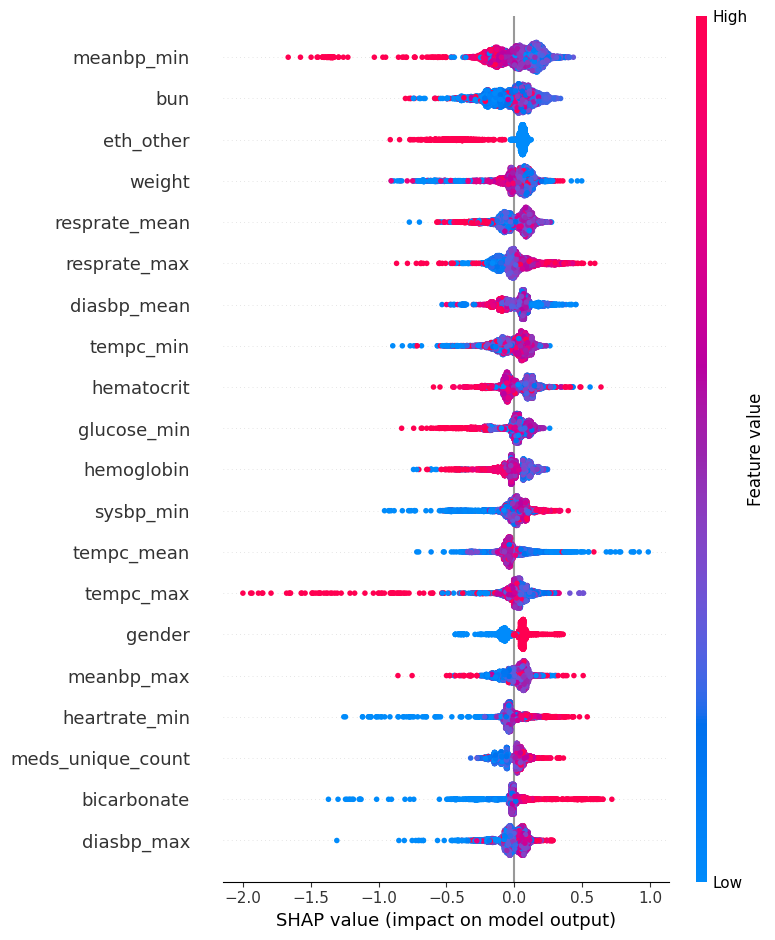

AUC = 0.54


<Figure size 640x480 with 0 Axes>

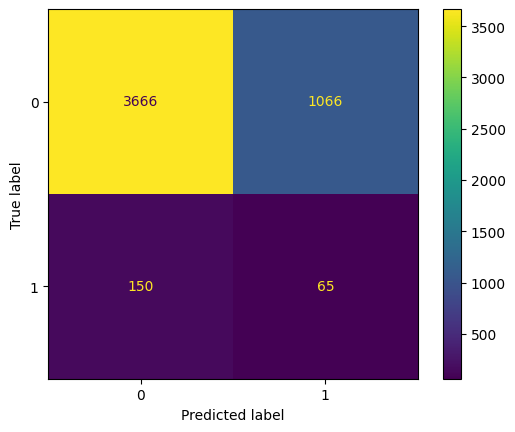

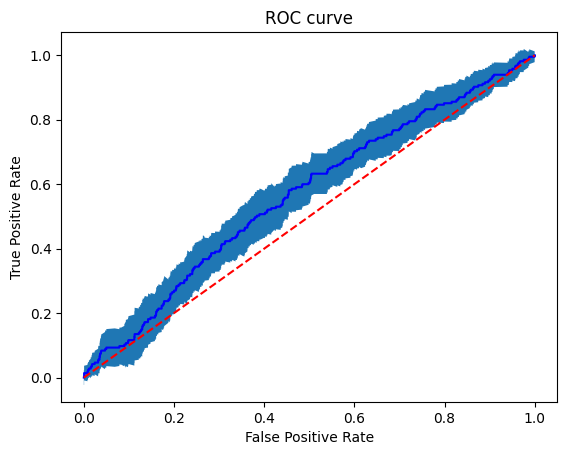

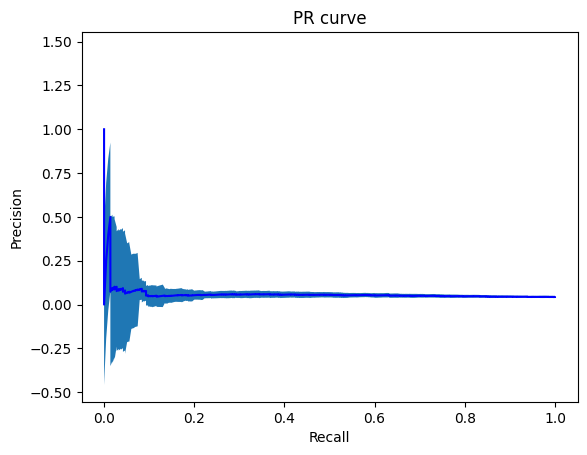

<IPython.core.display.Latex object>

label: mort_target
f1-score: 0.38572090866944836
accuracy: 0.7321609055993531
precision: 0.27350427350427353
recall: 0.6540880503144654


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


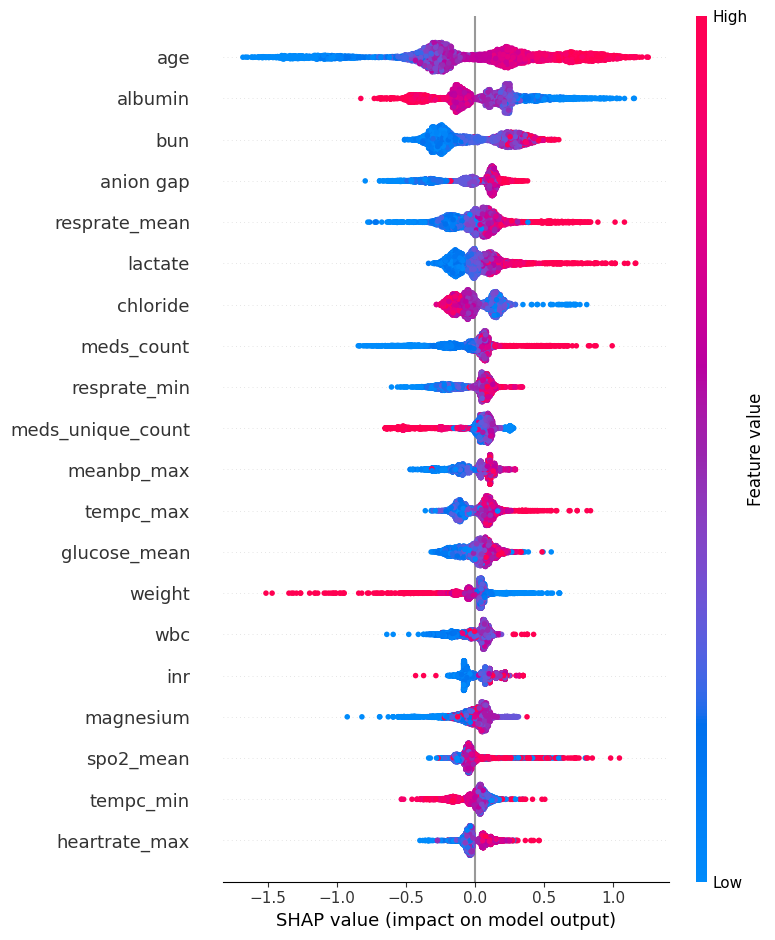

AUC = 0.78


<Figure size 640x480 with 0 Axes>

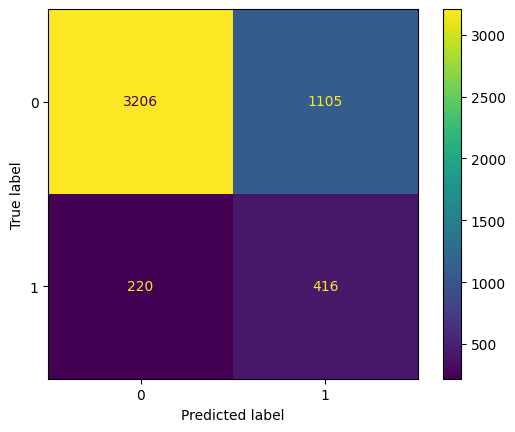

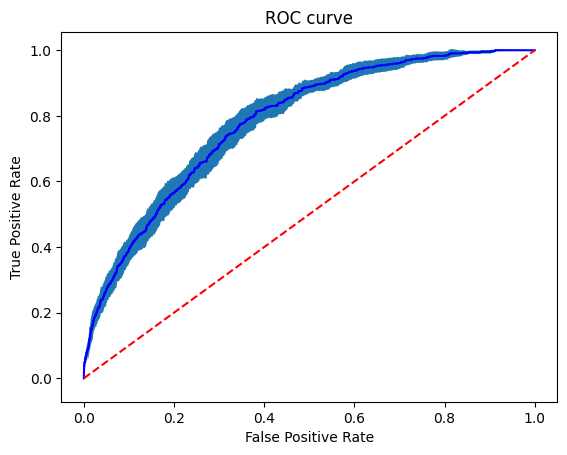

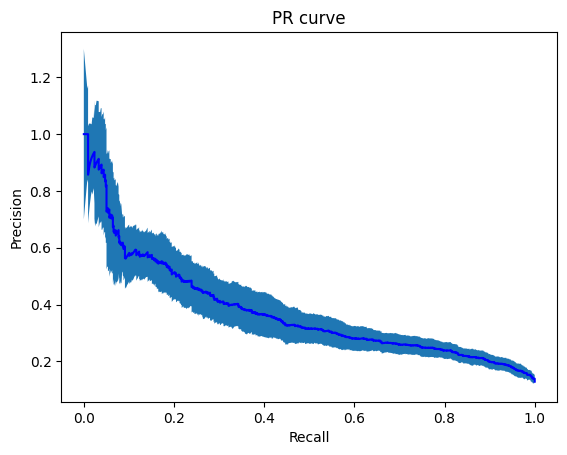

<IPython.core.display.Latex object>

label: prolonged_stay_target
f1-score: 0.7004553553751732
accuracy: 0.6941580756013745
precision: 0.7185215272136475
recall: 0.6832753959057551


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


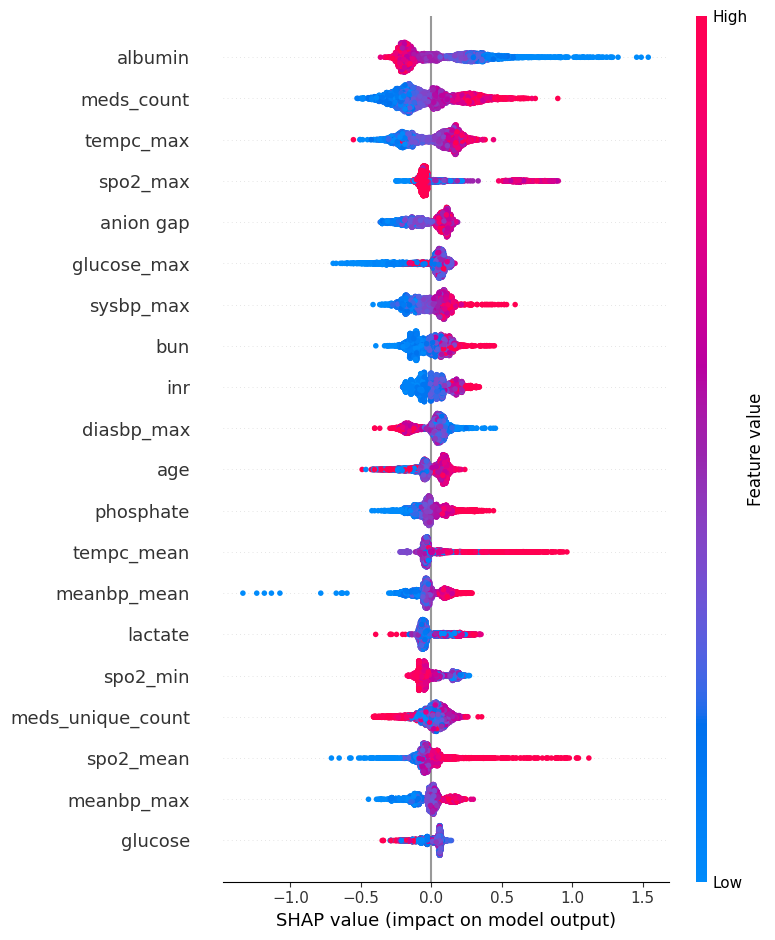

AUC = 0.75


<Figure size 640x480 with 0 Axes>

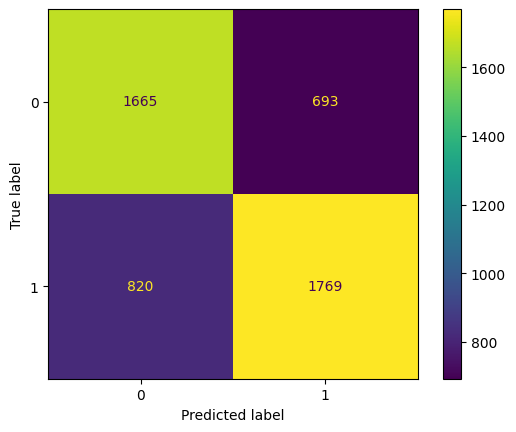

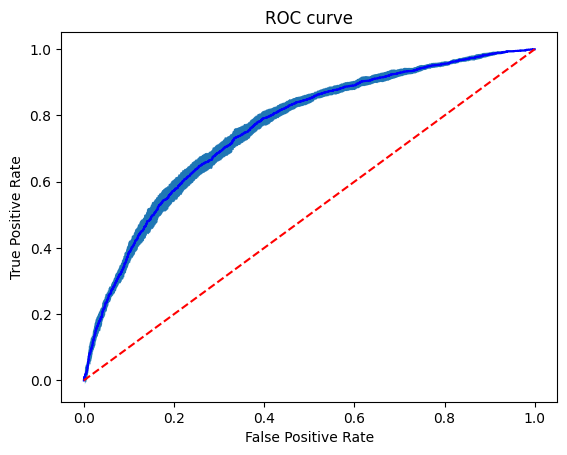

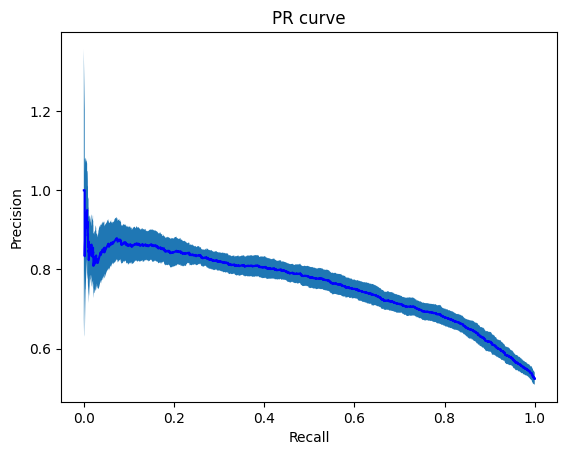

In [ ]:
# @title Only Tabular

tab_prc = ColumnTransformer(
    transformers=[
            ('features', 'passthrough', tabular_features)
    ])


# @title Tabular
pipeline_train(X_train,y_train['readmission_target'], X_test,y_test['readmission_target'], tab_prc, "LOGISTIC REGRESSION",'readmission_target', in_type='tabular', print_graphs=False)
pipeline_train(X_train,y_train['mort_target'], X_test,y_test['mort_target'], tab_prc, "LOGISTIC REGRESSION", 'mort_target',in_type='tabular', print_graphs=False)
pipeline_train(X_train,y_train['prolonged_stay_target'], X_test,y_test['prolonged_stay_target'], tab_prc, 'LOGISTIC REGRESSION',"prolonged_stay_target", in_type='tabular', print_graphs=False)

#RF
pipeline_train(X_train,y_train['readmission_target'], X_test,y_test['readmission_target'], tab_prc, "XGBOOST",'readmission_target', in_type='tabular', print_graphs=True)
pipeline_train(X_train,y_train['mort_target'], X_test,y_test['mort_target'], tab_prc, "XGBOOST", 'mort_target',in_type='tabular', print_graphs=True)
pipeline_train(X_train,y_train['prolonged_stay_target'], X_test,y_test['prolonged_stay_target'], tab_prc, "XGBOOST", 'prolonged_stay_target', in_type='tabular', print_graphs=True)


<IPython.core.display.Latex object>

label: readmission_target
f1-score: 0.08260869565217391
accuracy: 0.573478876086517
precision: 0.045563549160671464
recall: 0.4418604651162791


<IPython.core.display.Latex object>

label: mort_target
f1-score: 0.3162873189476796
accuracy: 0.5324439053972104
precision: 0.194757917728431
recall: 0.8411949685534591


<IPython.core.display.Latex object>

label: prolonged_stay_target
f1-score: 0.719600413365484
accuracy: 0.6709116636345259
precision: 0.6493627603357165
recall: 0.8068752414059482


<IPython.core.display.Latex object>

label: readmission_target
f1-score: 0.08142493638676845
accuracy: 0.5621588841722256
precision: 0.04479701353243117
recall: 0.44651162790697674


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


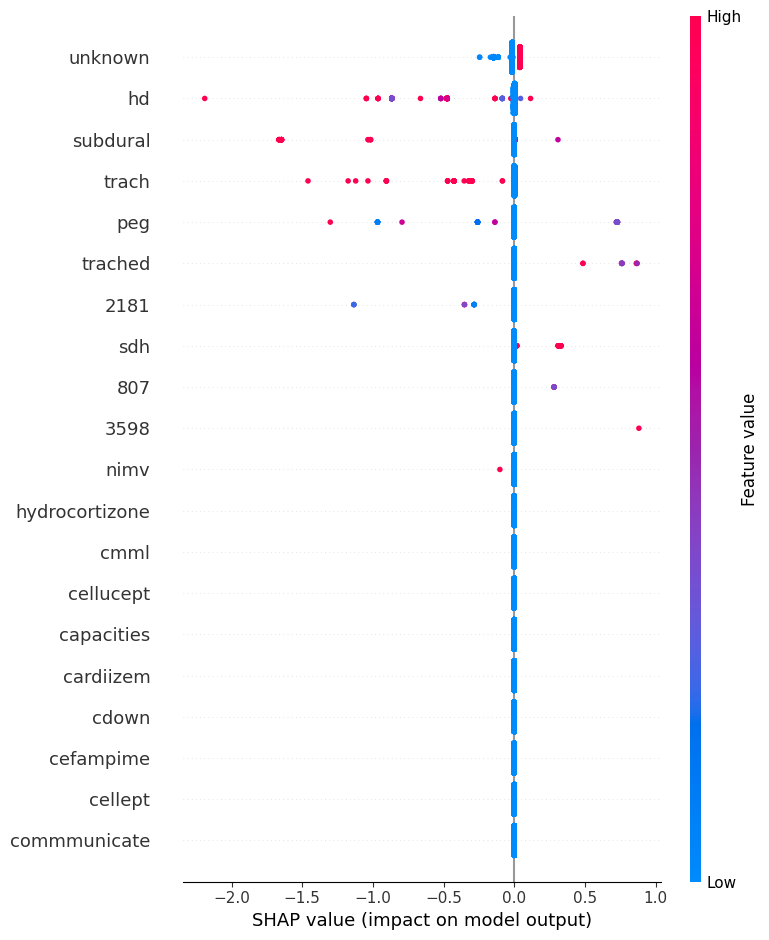

AUC = 0.50


<Figure size 640x480 with 0 Axes>

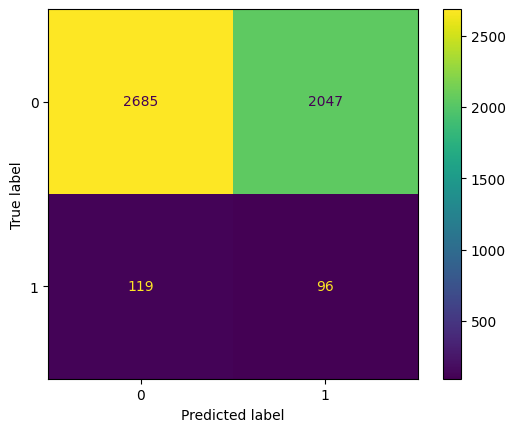

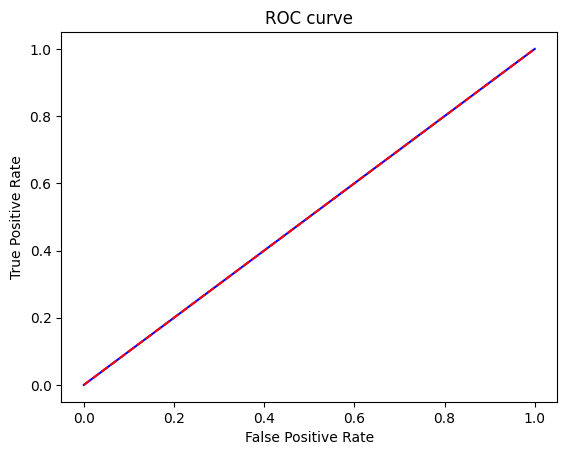

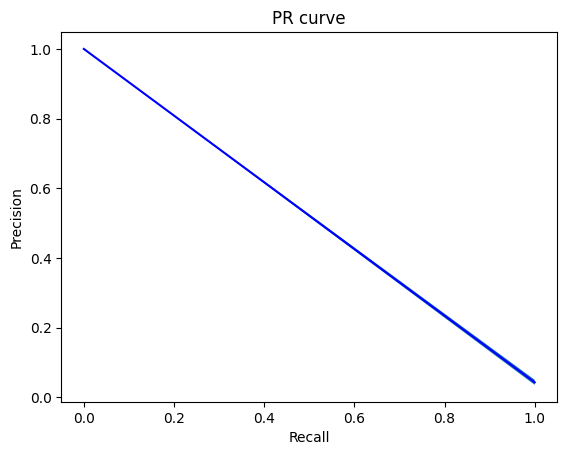

<IPython.core.display.Latex object>

label: mort_target
f1-score: 0.3123086344151868
accuracy: 0.5459874671518091
precision: 0.19391634980988592
recall: 0.8018867924528302


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


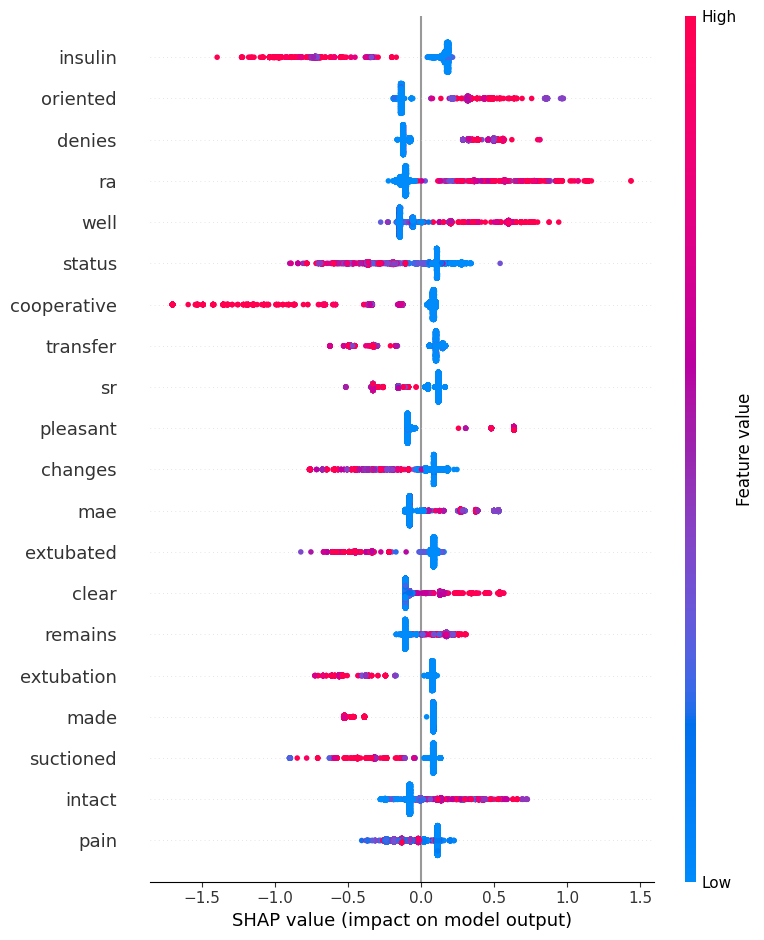

AUC = 0.54


<Figure size 640x480 with 0 Axes>

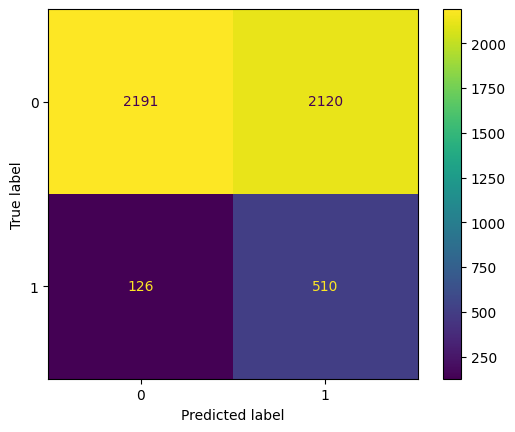

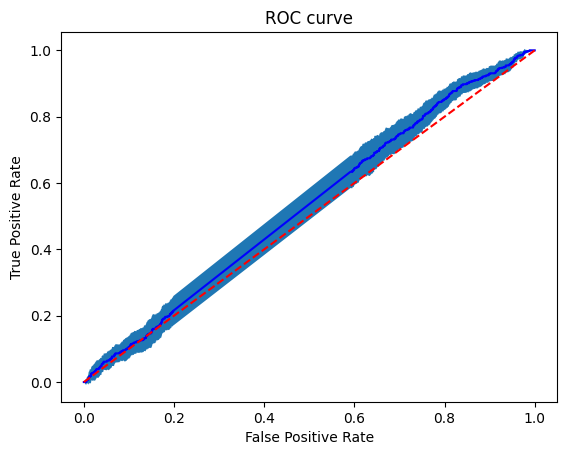

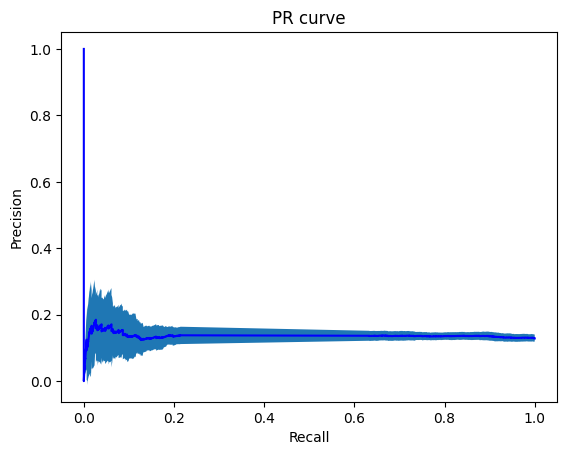

<IPython.core.display.Latex object>

label: prolonged_stay_target
f1-score: 0.7220770169018993
accuracy: 0.6775823731554478
precision: 0.6577777777777778
recall: 0.8003089996137505


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


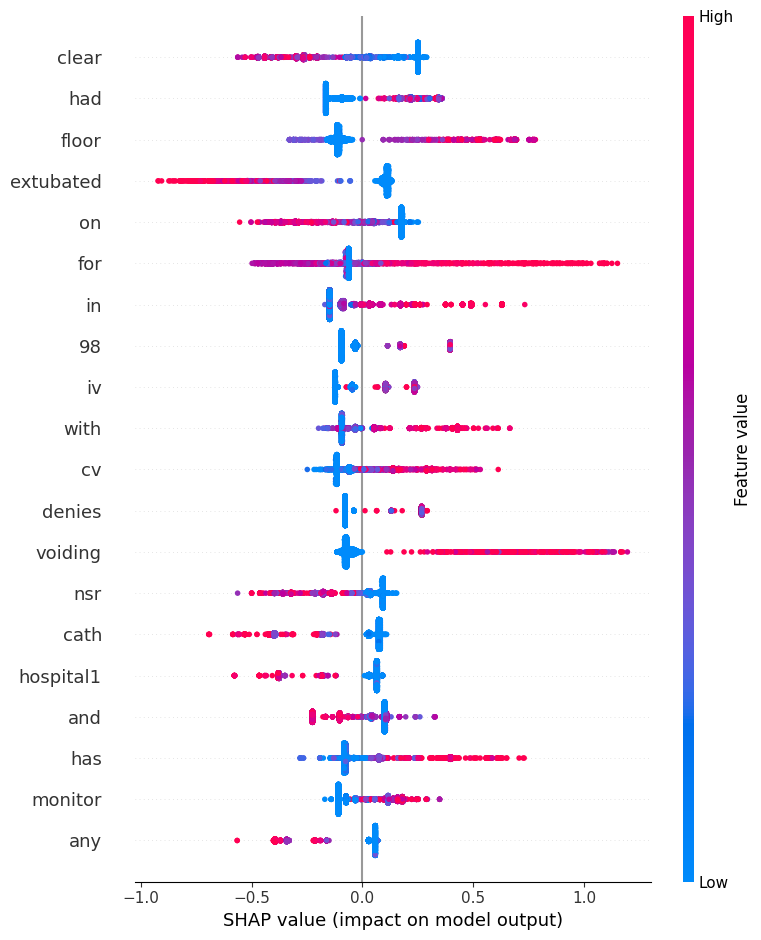

AUC = 0.50


<Figure size 640x480 with 0 Axes>

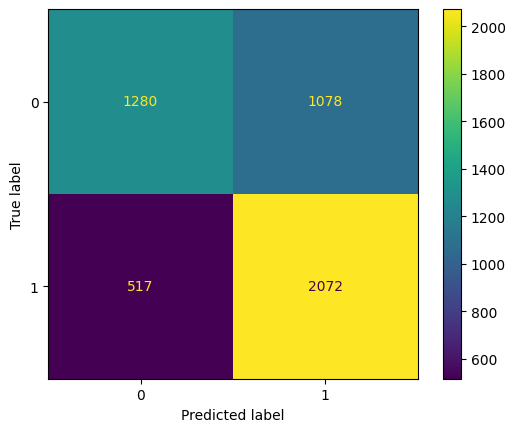

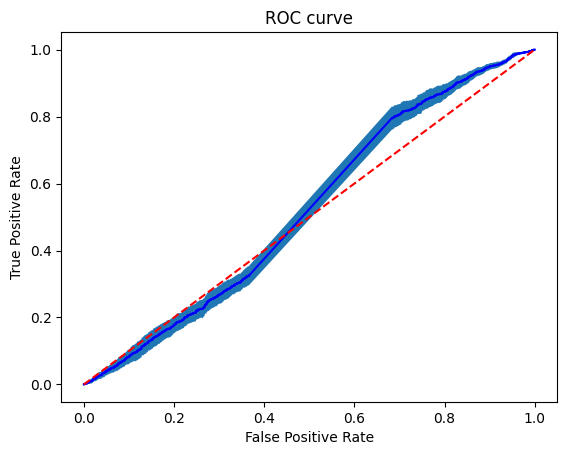

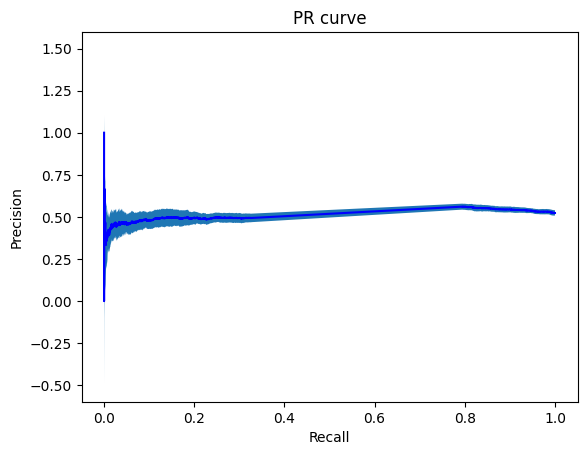

In [ ]:
# @title Only Text

top_k_text_features = 400

# Text transformer pipeline
text_transformer = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("KBest",SelectKBest(chi2, k=top_k_text_features))])
text_prc = ColumnTransformer(
    transformers=[
            ('text', text_transformer, 'all_notes')
    ])

# LR
pipeline_train(X_train,y_train['readmission_target'], X_test,y_test['readmission_target'], text_prc, "LOGISTIC REGRESSION",'readmission_target', in_type='text', print_graphs=False)
pipeline_train(X_train,y_train['mort_target'], X_test,y_test['mort_target'], text_prc, "LOGISTIC REGRESSION", 'mort_target',in_type='text', print_graphs=False)
pipeline_train(X_train,y_train['prolonged_stay_target'], X_test,y_test['prolonged_stay_target'], text_prc, 'LOGISTIC REGRESSION',"prolonged_stay_target", in_type='text', print_graphs=False)

#XGBOOST
pipeline_train(X_train,y_train['readmission_target'], X_test,y_test['readmission_target'], text_prc, "XGBOOST",'readmission_target', in_type='text', print_graphs=True)
pipeline_train(X_train,y_train['mort_target'], X_test,y_test['mort_target'], text_prc, "XGBOOST", 'mort_target',in_type='text', print_graphs=True)
pipeline_train(X_train,y_train['prolonged_stay_target'], X_test,y_test['prolonged_stay_target'], text_prc, 'XGBOOST',"prolonged_stay_target", in_type='text', print_graphs=True)


<IPython.core.display.Latex object>

label: readmission_target
f1-score: 0.11607738492328218
accuracy: 0.7321609055993531
precision: 0.06775700934579439
recall: 0.4046511627906977


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


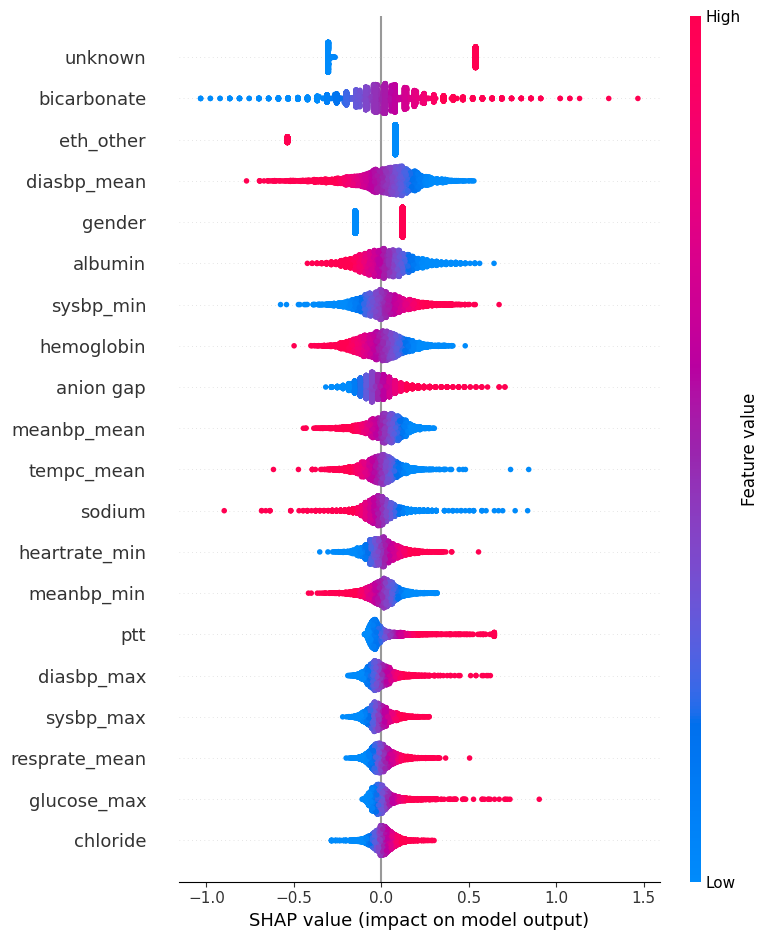

<IPython.core.display.Latex object>

label: mort_target
f1-score: 0.4098434004474273
accuracy: 0.7333737618758843
precision: 0.2864290181363352
recall: 0.720125786163522


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


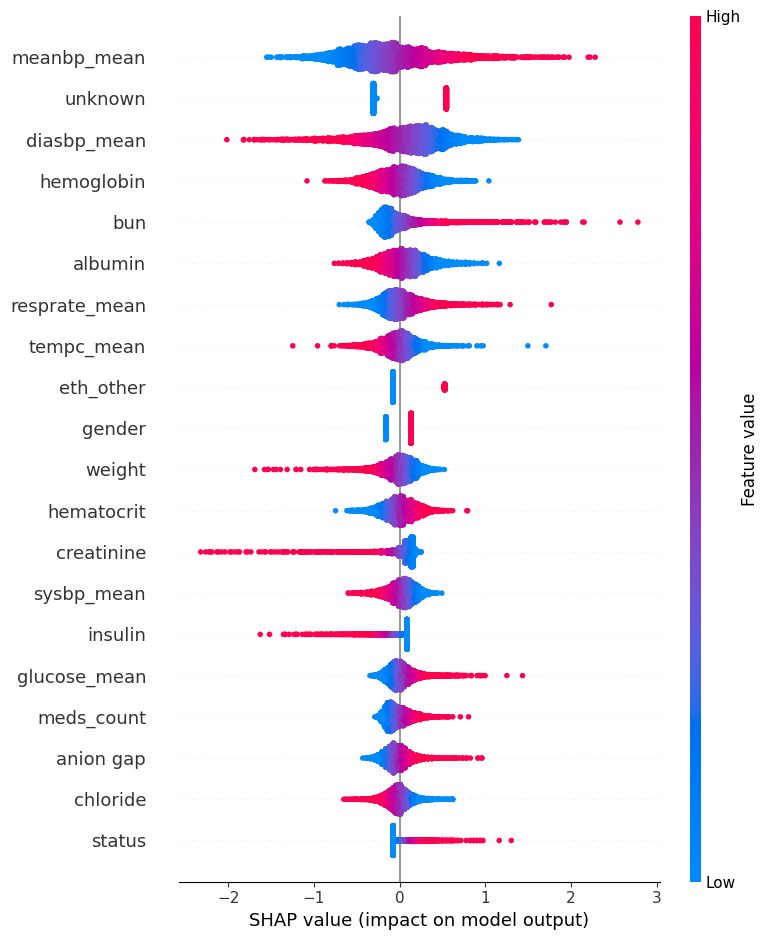

<IPython.core.display.Latex object>

label: prolonged_stay_target
f1-score: 0.7308781869688386
accuracy: 0.7119466343238327
precision: 0.7150776053215078
recall: 0.7473928157589803


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


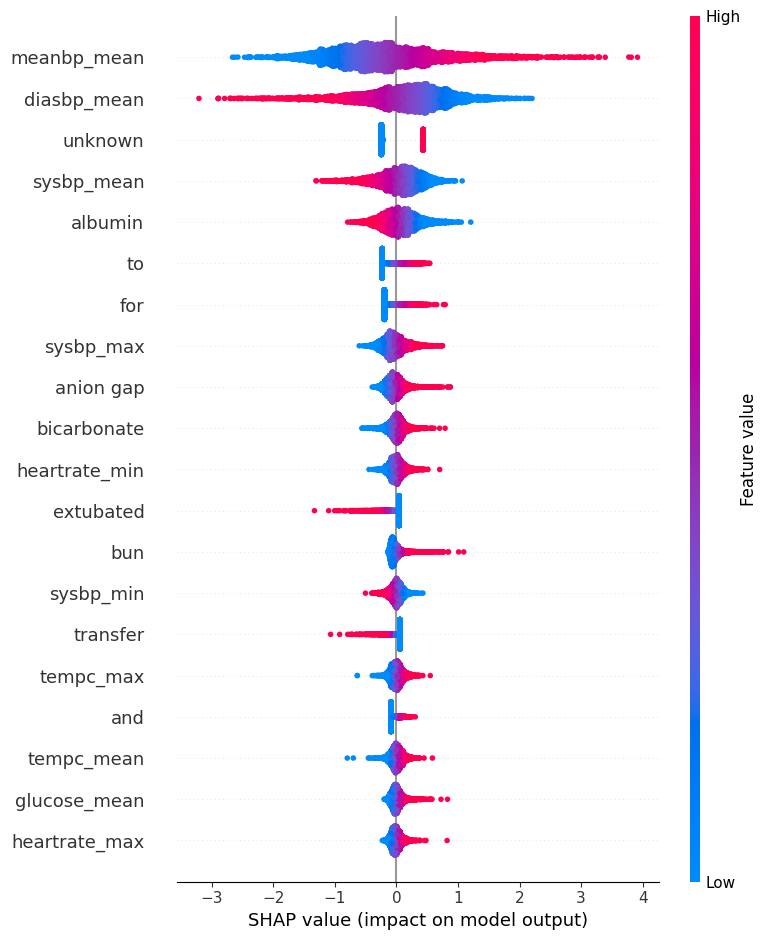

<IPython.core.display.Latex object>

label: readmission_target
f1-score: 0.09935205183585313
accuracy: 0.7471194663432383
precision: 0.05877342419080068
recall: 0.3209302325581395
AUC = 0.64


<Figure size 640x480 with 0 Axes>

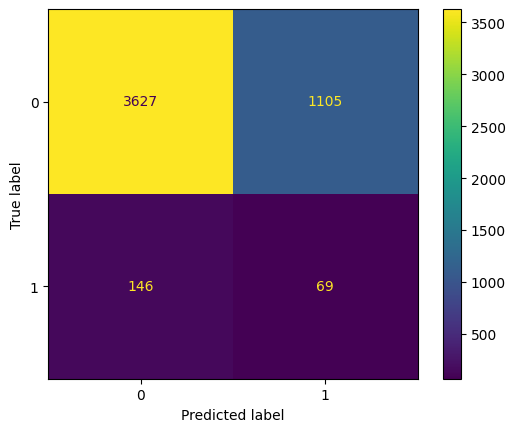

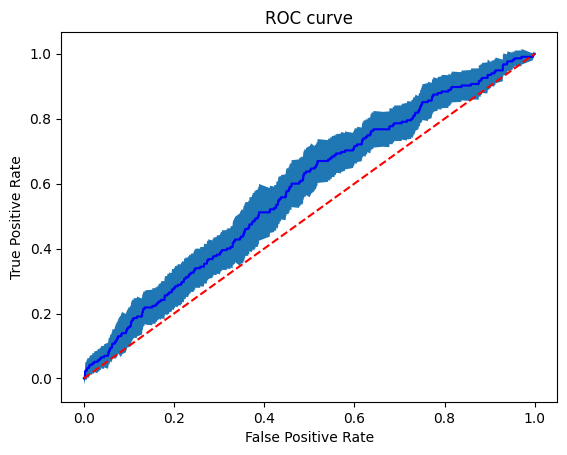

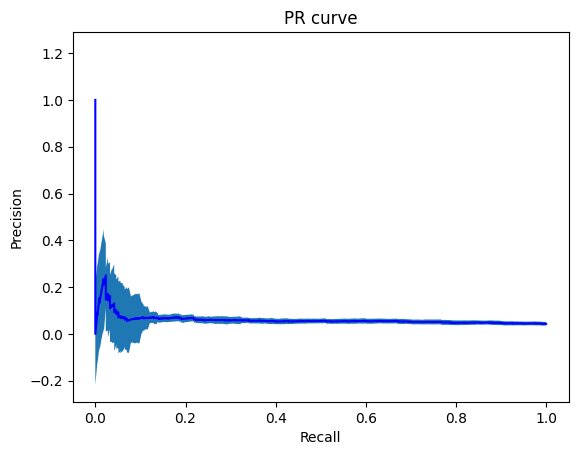

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


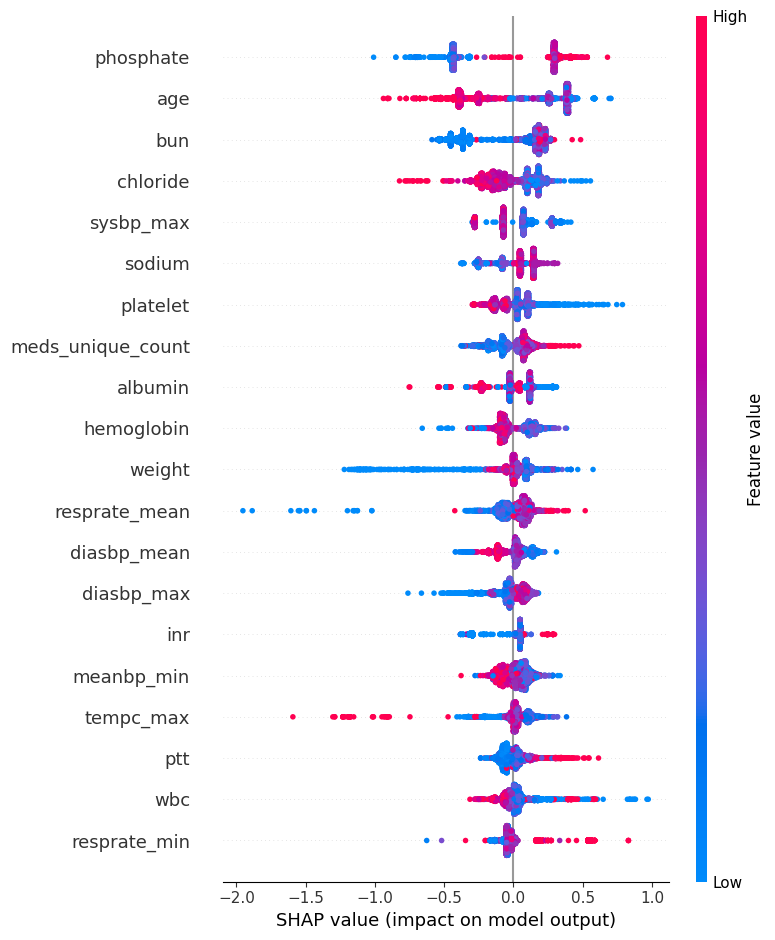

<IPython.core.display.Latex object>

label: mort_target
f1-score: 0.4076555023923445
accuracy: 0.749747321609056
precision: 0.29298486932599727
recall: 0.6698113207547169
AUC = 0.83


<Figure size 640x480 with 0 Axes>

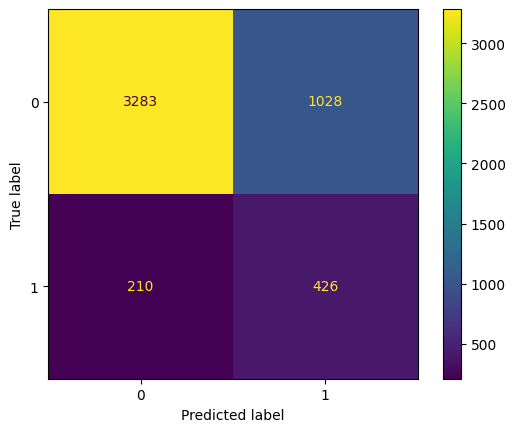

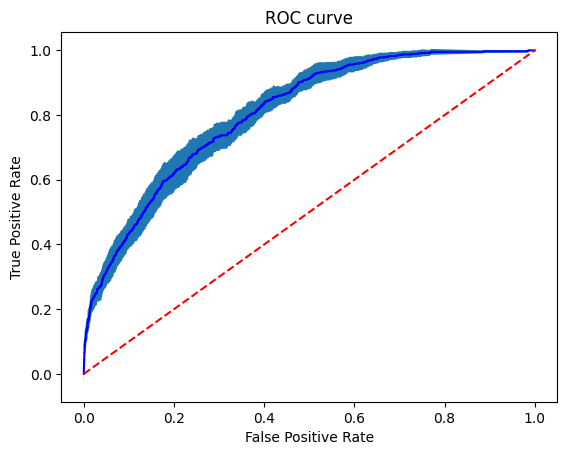

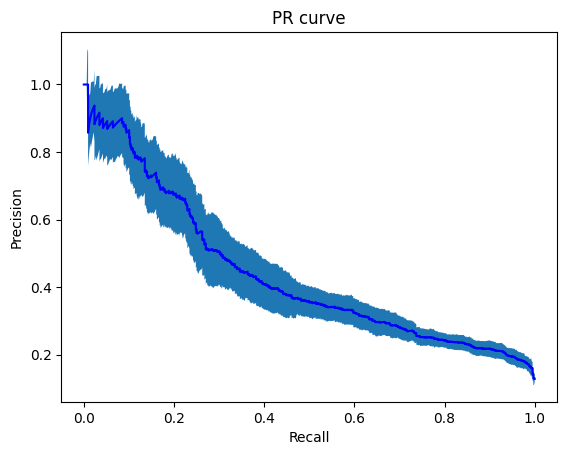

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


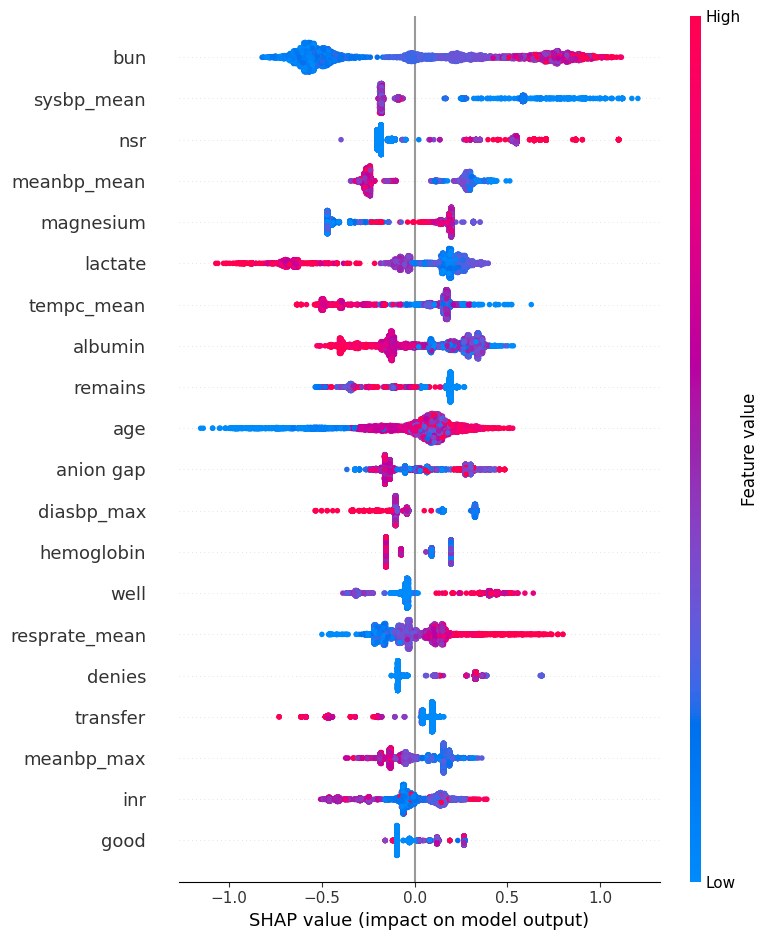

<IPython.core.display.Latex object>

label: prolonged_stay_target
f1-score: 0.7290335076505908
accuracy: 0.717202344855468
precision: 0.7311577311577312
recall: 0.7269215913480108
AUC = 0.78


<Figure size 640x480 with 0 Axes>

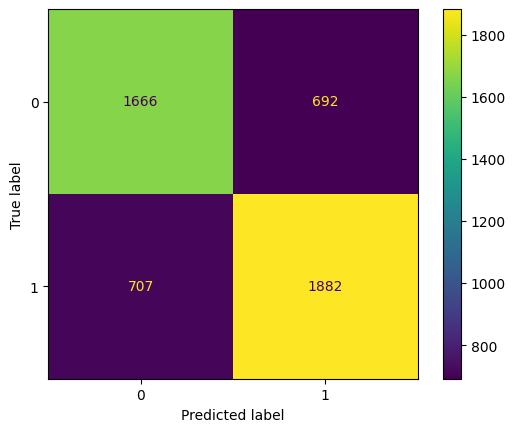

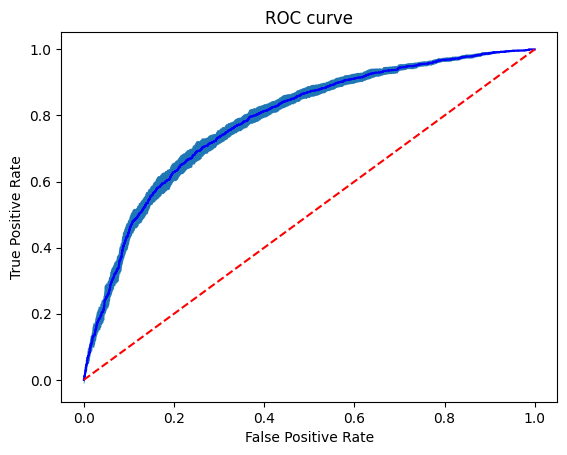

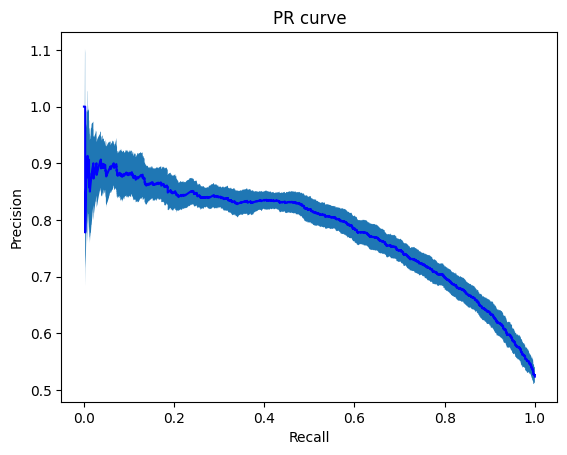

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


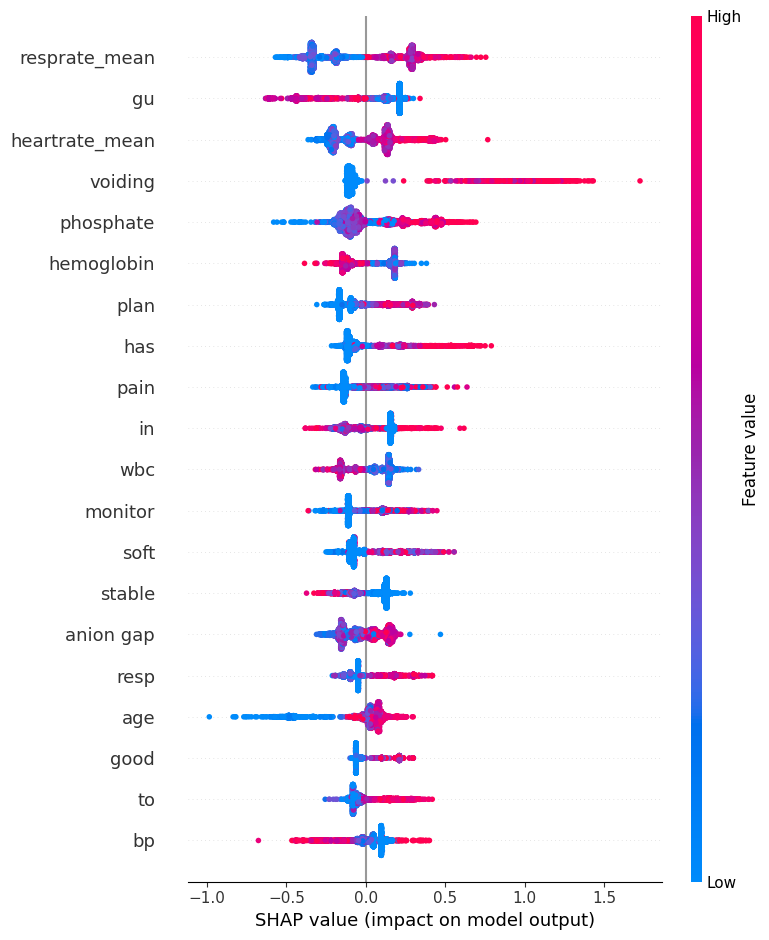

In [ ]:
# @title Text + Tabular

top_k_text_features = 400

# Text transformer pipeline
# Text transformer pipeline
text_transformer = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("KBest",SelectKBest(chi2, k=top_k_text_features))])
both_prc = ColumnTransformer(
    transformers=[
            ('text', text_transformer, 'all_notes'),
            ('tabular','passthrough',tabular_features)
    ])

# LR
pipeline_train(X_train,y_train['readmission_target'], X_test,y_test['readmission_target'], both_prc, "LOGISTIC REGRESSION",'readmission_target', in_type='both', print_graphs=False)
pipeline_train(X_train,y_train['mort_target'], X_test,y_test['mort_target'], both_prc, "LOGISTIC REGRESSION", 'mort_target',in_type='both', print_graphs=False)
pipeline_train(X_train,y_train['prolonged_stay_target'], X_test,y_test['prolonged_stay_target'], both_prc, 'LOGISTIC REGRESSION',"prolonged_stay_target", in_type='both', print_graphs=False)

#XGBOOST
model_readmission, preprocess_readmission = pipeline_train(X_train,y_train['readmission_target'], X_test,y_test['readmission_target'], both_prc, "XGBOOST",'readmission_target', in_type='both', print_graphs=True)
model_mort, preprocess_mort = pipeline_train(X_train,y_train['mort_target'], X_test,y_test['mort_target'], both_prc, "XGBOOST", 'mort_target',in_type='both', print_graphs=True)
model_prolonged, preprocess_prolonged = pipeline_train(X_train,y_train['prolonged_stay_target'], X_test,y_test['prolonged_stay_target'], both_prc, 'XGBOOST',"prolonged_stay_target", in_type='both', print_graphs=True)


In [ ]:
#@title Save final models
from joblib import dump

dump(model_readmission, '/content/drive/MyDrive/ProjectMLHC/final_model/model_readmission')
dump(model_mort, '/content/drive/MyDrive/ProjectMLHC/final_model/model_mort')
dump(model_prolonged, '/content/drive/MyDrive/ProjectMLHC/final_model/model_prolonged')

dump(preprocess_readmission,'/content/drive/MyDrive/ProjectMLHC/final_model/preprocess_readmission')
dump(preprocess_mort, '/content/drive/MyDrive/ProjectMLHC/final_model/preprocess_mort')
dump(preprocess_prolonged, '/content/drive/MyDrive/ProjectMLHC/final_model/preprocess_prolonged')


['/content/drive/MyDrive/ProjectMLHC/final_model/preprocess_prolonged']

In [ ]:
from joblib import dump

dump(tab_preprocess, '/content/drive/MyDrive/ProjectMLHC/final_model/tab_preprocess')

['/content/drive/MyDrive/ProjectMLHC/final_model/tab_preprocess']

In [27]:
from joblib import load

model_readmission = load( '/content/drive/MyDrive/ProjectMLHC/final_model/model_readmission')
model_mort = load('/content/drive/MyDrive/ProjectMLHC/final_model/model_mort')
model_prolonged = load('/content/drive/MyDrive/ProjectMLHC/final_model/model_prolonged')

preprocess_readmission = load( '/content/drive/MyDrive/ProjectMLHC/final_model/preprocess_readmission')
preprocess_mort = load('/content/drive/MyDrive/ProjectMLHC/final_model/preprocess_mort')
preprocess_prolonged = load('/content/drive/MyDrive/ProjectMLHC/final_model/preprocess_prolonged')


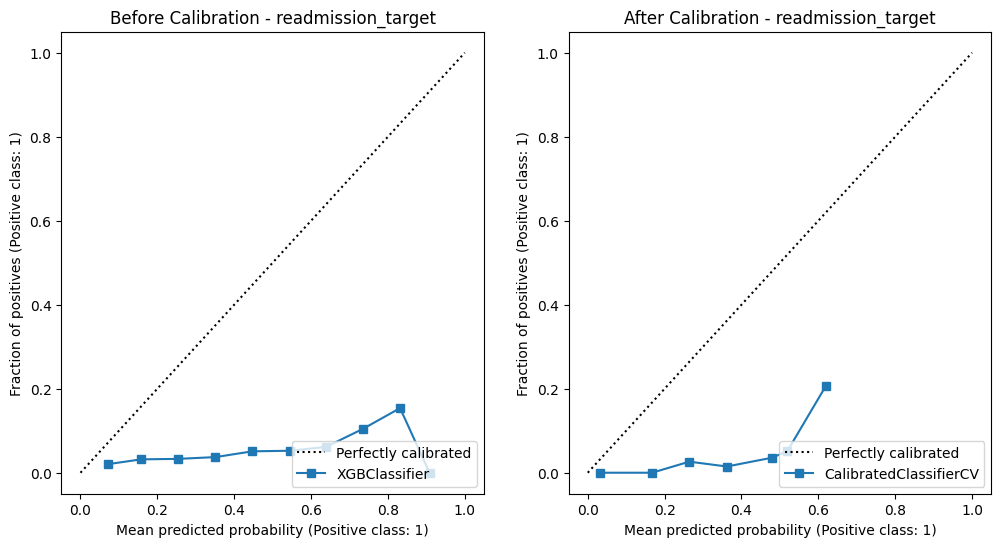

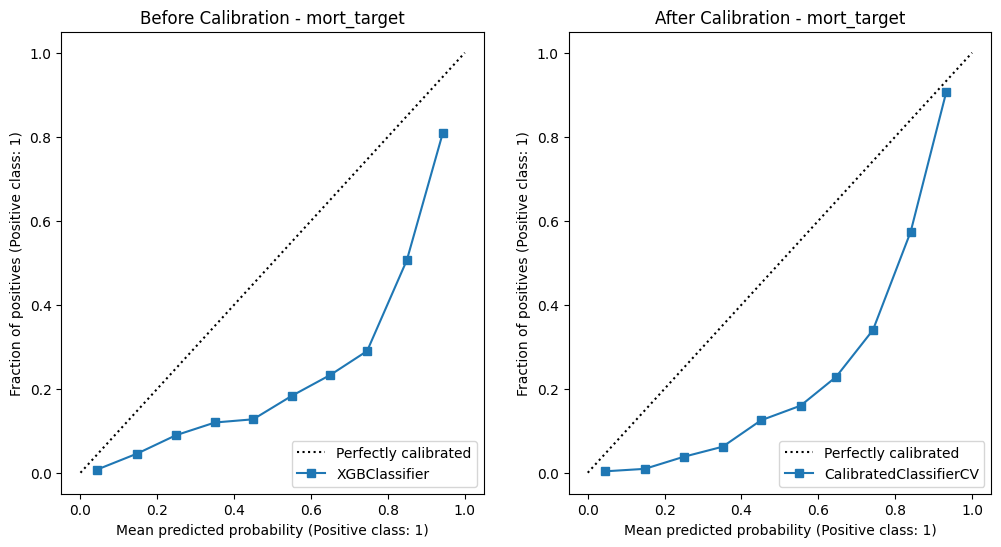

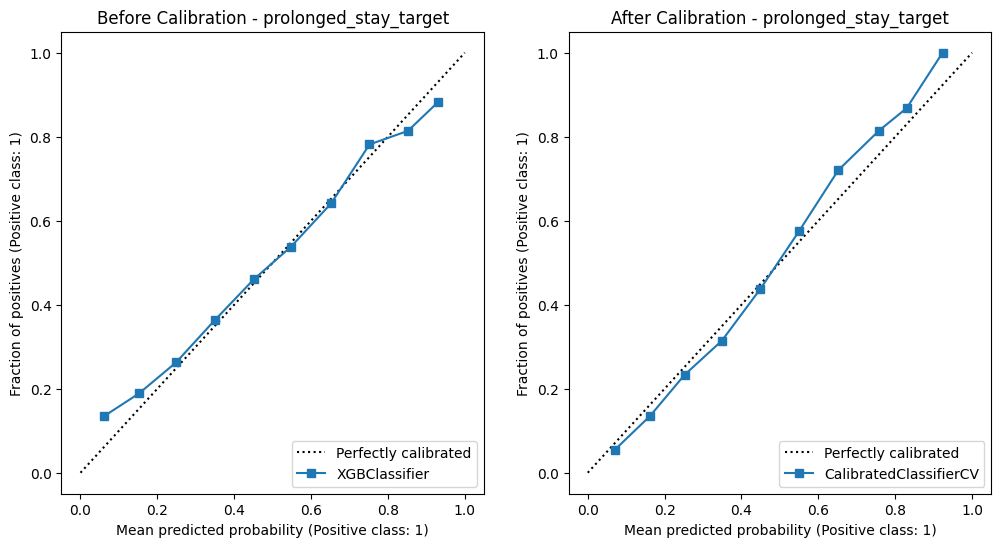

In [32]:
import pickle
# @title Calibrate final models
# We re-run the calibrated
X_test = X_test.copy()
X_test = X_test.copy()
calibrated_readmission = calibrate(model_readmission,preprocess_readmission,X_test,y_test['readmission_target'], X_train,y_train['readmission_target'], 'readmission_target')
calibrated_mort = calibrate(model_mort,preprocess_mort,X_test,y_test['mort_target'],X_train,y_train['mort_target'], 'mort_target')
calibrated_prolonged = calibrate(model_prolonged,preprocess_prolonged,X_test,y_test['prolonged_stay_target'],X_train,y_train['prolonged_stay_target'], 'prolonged_stay_target')

In [34]:
# @title Save calibrated models
from joblib import dump
dump(calibrated_readmission, '/content/drive/MyDrive/ProjectMLHC/final_model/model_readmission1')
dump(calibrated_mort, '/content/drive/MyDrive/ProjectMLHC/final_model/model_mort1')
dump(calibrated_prolonged, '/content/drive/MyDrive/ProjectMLHC/final_model/model_prolonged1')


['/content/drive/MyDrive/ProjectMLHC/final_model/model_prolonged1']

## BART
BART is a BERT-like Transformer model. We use a model called Bio-BART, pretrained on medical data and further fine-tune it for MIMIC-3 note classification.
https://arxiv.org/pdf/2204.03905.pdf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers
!pip install datasets
!pip install wandb
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, EvalPrediction, AutoConfig, RobertaModel, RobertaForSequenceClassification, BartModel, BartConfig, BartPreTrainedModel
from datasets import load_dataset
import evaluate
import torch
import gc
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput, Seq2SeqSequenceClassifierOutput
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from typing import Optional, Union, Tuple,List


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/6

In [ ]:
# @title Tokenize


def tokenize_function(example, notes_col, target_col):
  tokenized = tokenizer(example[notes_col], padding="max_length", truncation=True, max_length=1024)
  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']
  # Convert tabular features into a DataFrame
  df = pd.DataFrame({feature: example[feature] for feature in tabular_features})
  df = df.astype(float)

  # Collapse the columns into a single column containing arrays
  tabular_data = df.apply(lambda row: row.values, axis=1).tolist()

  return {
      "labels": example[target_col],
      'input_ids': input_ids,
      'attention_mask' : attention_mask,
      'extra_data': tabular_data
  }


In [ ]:
# @title Train
from sklearn.utils.class_weight import compute_class_weight

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


def train(model, train_dataset):
    training_arguments = TrainingArguments(
        output_dir='/temp',
        per_device_train_batch_size=4,
        warmup_ratio=0.03
    )

    # Create the Trainer instance
    trainer = CustomTrainer(
        model=model,
        args=training_arguments,
        train_dataset=train_dataset,
        )
    trainer.train()
    return trainer

In [ ]:
!pip install wandb
import wandb
wandb.login(key='XXXX')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


ValueError: ignored

### Run

In [ ]:
# @title Load model
from transformers import BartForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained('GanjinZero/biobart-base')
model = BartForSequenceClassification.from_pretrained('/content/drive/MyDrive/ProjectMLHC/BART_NOTES_ONLY', num_labels=2)


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


### Test

In [ ]:
# @title Data

train_data, test_data = get_tokenized_datasets(note_col='first_notes',target_col='prolonged_stay_target', tokenize_function=tokenize_function, fill_missing_notes=False)




A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       gender       age  eth_asian  eth_black  eth_hispanic  eth_other  \
0         0.0  0.201365        0.0        0.0           0.0        0.0   
1         1.0  0.211604        0.0        0.0           0.0        0.0   
2         1.0  0.232082        0.0        0.0           0.0        0.0   
3         1.0  0.075085        0.0        0.0           0.0        0.0   
4         0.0  0.187713        0.0        0.0           0.0        0.0   
...       ...       ...        ...        ...           ...        ...   
12048     1.0  0.201365        0.0        0.0           0.0        0.0   
12049     1.0  0.218430        0.0        0.0           0.0        1.0   
12050     1.0  0.105802        0.0        1.0           0.0        0.0   
12051     0.0  0.184300        0.0        0.0           0.0        0.0   
12052     0.0  0.040956        0.0        0.0           0.0        0.0   

       eth_white  diasbp_max  glucose_max  heartrate_max  ...  platelet  \
0            1.0    0.205263     0.0

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/12053 [00:00<?, ? examples/s]

Map:   0%|          | 0/3014 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
                                  per_device_eval_batch_size=1,
                                  output_dir = '/')
trainer = Trainer(
    model=model,
    args= training_args
)


In [ ]:
# @title Test

prediction_output = trainer.predict(test_data.select(range(2000)))
predicted= prediction_output.predictions[0].argmax(-1)
labels= test_data.select(range(2000))['labels']
print(f'label: BART')
print(f"f1-score: {f1_score(labels, predicted)}")
print(f"accuracy: {accuracy_score(labels, predicted)}")
print(f"precision: {precision_score(labels, predicted)}")
print(f"recall: {recall_score(labels, predicted)}")


label: BART
f1-score: 0.6690721649484536
accuracy: 0.679
precision: 0.6451292246520874
recall: 0.6948608137044968


## DAN
A deep averging network (DAN) is a NN that classify text using its averaged static embeddings.
https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf

In [ ]:
# @title Setup

!pip install datasets
!pip install transformers==4.28.0

from datasets import load_dataset

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-b8mex_gn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-b8mex_gn
  Resolved https://github.com/huggingface/accelerate to commit a87c95da9e3b416fb10a0e7dac7d397c015c3ed5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.24.0.dev0-py3-none-any.whl size=258134 sha256=f99a50ee244ef8e2bcf599a8881606aedec745989e7a78276ad5474f84ecf276
  Stored in directory: /tmp/pip-ephem-wheel-cache-nf9i1xvm/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 23.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.33.2
    Uninstalling transformers-4.33.2:
      Successfully uninst

### Preprocessing

In [ ]:
# @title Load embeddings
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:09<00:00, 51.8MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 39.1MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# @title Padding

def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [ ]:
# @title Tokenize

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example, notes_col, target_col):
  sentences = [x.lower() for x in example[notes_col]]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  # Convert tabular features into a DataFrame
  df = pd.DataFrame({feature: example[feature] for feature in tabular_features})
  df = df.astype(float)

  # Collapse the columns into a single column containing arrays
  tabular_data = df.apply(lambda row: row.values, axis=1).tolist()

  return {
      "labels": example[target_col],
      'input_ids': tokenized_idx,
      'tabular_data': tabular_data
  }


In [ ]:
# @title Data Collator
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
    def __call__(self, features):
        features_dict = {}

        if "labels" in features[0]:
            features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

        # TEXT
        input_ids = [x.pop("input_ids") for x in features]
        max_len = max(len(x) for x in input_ids)
        masks = [[1] * len(x) for x in input_ids]

        features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x, max_len) for x in input_ids]).long()
        features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x, max_len) for x in masks]).long()

        # TABULAR
        features_dict["tabular_data"] = torch.tensor([x.pop("tabular_data") for x in features]).float()

        return features_dict


### Model

In [ ]:
# @title Deep Averaging
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DAN(nn.Module):
    def __init__(self, num_hidden_layers, activation_function, d_rate, tabular_dim):
        super().__init__()
        self.num_labels = 2
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
        self.dropout_rate = d_rate
        combined_dim = self.embeddings.embedding_dim + tabular_dim # Combined size of text and tabular features

        self.tabular_layers = nn.Sequential(
            nn.Linear(tabular_dim, tabular_dim),
            activation_function(),
            nn.Linear(tabular_dim, tabular_dim),
            activation_function(),

            nn.Linear(tabular_dim, tabular_dim),
        ).to(device)

        self.text_layers = nn.Sequential(
            nn.Linear(self.embeddings.embedding_dim, self.embeddings.embedding_dim),
            activation_function(),
            nn.Linear(self.embeddings.embedding_dim, self.embeddings.embedding_dim),
            activation_function(),
            nn.Linear(self.embeddings.embedding_dim,self.embeddings.embedding_dim ),
        ).to(device)




        layers = []
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(combined_dim, combined_dim))
            layers.append(activation_function())

        output_layer = nn.Linear(combined_dim, self.num_labels)
        layers.append(output_layer)
        self.classifier = nn.Sequential(*layers)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_masks, tabular_data,labels=None):
        # Average embeddings
        if (self.dropout_rate > 0):
            word_drop = torch.tensor([[1 if random.random() >= self.dropout_rate else 0 for x in range(attention_masks.shape[1])] for x in range(attention_masks.shape[0])]).to(device)
            attention_masks = torch.mul(word_drop, attention_masks)

        dropout_ids = torch.mul(input_ids, attention_masks)
        sum_masks = attention_masks.sum(1)
        embeddings = self.embeddings(dropout_ids)
        sum_embeddings = torch.sum(embeddings, 1)

        # Process text and tabular independently and then combine
        avg_text = torch.div(sum_embeddings, sum_masks.unsqueeze(1))
        avg_text = self.text_layers(avg_text)

        tabular_output = self.tabular_layers(tabular_data)

        merged_features = torch.cat((avg_text, tabular_output), dim=1)  # Concatenating features
        res = self.classifier(merged_features)

        return {"logits": res}


In [ ]:
# @title Train
from transformers import Trainer
from transformers import TrainingArguments,PrinterCallback
from transformers import TrainerCallback, ProgressCallback
from sklearn.utils.class_weight import compute_class_weight
from transformers import Trainer

from transformers import Trainer
from transformers import TrainingArguments, PrinterCallback
from transformers import TrainerCallback, ProgressCallback
from sklearn.utils.class_weight import compute_class_weight

class CustomTrainer(Trainer):
    def __init__(self, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights_tensor = weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")

        # forward pass
        outputs = model(inputs["input_ids"], attention_masks=inputs["attention_masks"], tabular_data=inputs["tabular_data"])
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights_tensor.to(logits.device))
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

co = DataCollatorWithPadding()

training_args = TrainingArguments("DAN",
                                  num_train_epochs= 14,
                                  per_device_train_batch_size=384,
                                  learning_rate=0.001,
                                  save_total_limit=2,
                                  log_level="error")

def train(train_dataset, num_hidden_layers, activation, d_rate, class_weights_tensor):
    model = DAN(num_hidden_layers, activation, d_rate, len(tabular_features))
    trainer = CustomTrainer(
        model=model,
        data_collator=co,
        args=training_args,
        train_dataset=train_dataset,
        callbacks=[ProgressCallback],
        weights=class_weights_tensor
    )

    trainer.train()
    return trainer


### Run

In [ ]:
!pip install wandb
import wandb
wandb.login(key='X')

In [ ]:
def train_and_eval(target_col, note_col):
    train_data, test_data = get_tokenized_datasets(note_col=note_col,target_col=target_col, tokenize_function=tokenize_function)
    class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_data['labels'])
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

    model = train(train_data,1,nn.ReLU,0,class_weights_tensor)
    prediction_output = model.predict(test_data)

    eval(model_name='DAN',
        predicted= prediction_output.predictions.argmax(-1),labels= prediction_output.label_ids, print_graphs=False)


In [ ]:
train_and_eval('prolonged_stay_target','all_notes')
train_and_eval('readmission_target','all_notes')
train_and_eval('mort_target','all_notes')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       gender       age  eth_asian  eth_black  eth_hispanic  eth_other  \
0         0.0  0.180887        0.0        0.0           0.0        0.0   
1         1.0  0.170648        0.0        0.0           0.0        0.0   
2         1.0  0.156997        0.0        0.0           0.0        0.0   
3         0.0  0.215017        0.0        0.0           1.0        0.0   
4         0.0  0.075085        0.0        0.0           0.0        0.0   
...       ...       ...        ...        ...           ...        ...   
19781     1.0  0.146758        0.0        0.0           0.0        0.0   
19782     0.0  0.208191        0.0        0.0           0.0        0.0   
19783     1.0  0.221843        0.0        0.0           0.0        0.0   
19784     0.0  0.218430        0.0        0.0           0.0        0.0   
19785     1.0  0.238908        0.0        0.0           0.0        0.0   

       eth_white  diasbp_max  glucose_max  heartrate_max  ...  platelet  \
0            1.0    0.256545     0.0

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/19786 [00:00<?, ? examples/s]

Map:   0%|          | 0/4947 [00:00<?, ? examples/s]

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


  0%|          | 0/728 [00:00<?, ?it/s]

{'loss': 0.6092, 'learning_rate': 0.0003131868131868132, 'epoch': 9.62}
{'loss': 0.6092, 'learning_rate': 0.0003131868131868132, 'epoch': 9.62}
{'train_runtime': 1440.471, 'train_samples_per_second': 192.301, 'train_steps_per_second': 0.505, 'train_loss': 0.5989488664564195, 'epoch': 14.0}
{'train_runtime': 1440.471, 'train_samples_per_second': 192.301, 'train_steps_per_second': 0.505, 'train_loss': 0.5989488664564195, 'epoch': 14.0}


  0%|          | 0/619 [00:00<?, ?it/s]

<IPython.core.display.Latex object>

label: 
f1-score: 0.7203094777562864
accuracy: 0.7077016373559734
precision: 0.7214258039519567
recall: 0.7191966010042488



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       gender       age  eth_asian  eth_black  eth_hispanic  eth_other  \
0         0.0  0.180887        0.0        0.0           0.0        0.0   
1         1.0  0.170648        0.0        0.0           0.0        0.0   
2         1.0  0.156997        0.0        0.0           0.0        0.0   
3         0.0  0.215017        0.0        0.0           1.0        0.0   
4         0.0  0.075085        0.0        0.0           0.0        0.0   
...       ...       ...        ...        ...           ...        ...   
19781     1.0  0.146758        0.0        0.0           0.0        0.0   
19782     0.0  0.208191        0.0        0.0           0.0        0.0   
19783     1.0  0.221843        0.0        0.0           0.0        0.0   
19784     0.0  0.218430        0.0        0.0           0.0        0.0   
19785     1.0  0.238908        0.0        0.0           0.0        0.0   

       eth_white  diasbp_max  glucose_max  heartrate_max  ...  platelet  \
0            1.0    0.256545     0.0

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/19786 [00:00<?, ? examples/s]

Map:   0%|          | 0/4947 [00:00<?, ? examples/s]

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


  0%|          | 0/728 [00:00<?, ?it/s]

{'loss': 0.6826, 'learning_rate': 0.0003131868131868132, 'epoch': 9.62}
{'loss': 0.6826, 'learning_rate': 0.0003131868131868132, 'epoch': 9.62}
{'train_runtime': 1434.8365, 'train_samples_per_second': 193.056, 'train_steps_per_second': 0.507, 'train_loss': 0.6791474268986628, 'epoch': 14.0}
{'train_runtime': 1434.8365, 'train_samples_per_second': 193.056, 'train_steps_per_second': 0.507, 'train_loss': 0.6791474268986628, 'epoch': 14.0}


  0%|          | 0/619 [00:00<?, ?it/s]

<IPython.core.display.Latex object>

label: 
f1-score: 0.10173802458668928
accuracy: 0.5716595916717202
precision: 0.055970149253731345
recall: 0.5581395348837209



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       gender       age  eth_asian  eth_black  eth_hispanic  eth_other  \
0         0.0  0.180887        0.0        0.0           0.0        0.0   
1         1.0  0.170648        0.0        0.0           0.0        0.0   
2         1.0  0.156997        0.0        0.0           0.0        0.0   
3         0.0  0.215017        0.0        0.0           1.0        0.0   
4         0.0  0.075085        0.0        0.0           0.0        0.0   
...       ...       ...        ...        ...           ...        ...   
19781     1.0  0.146758        0.0        0.0           0.0        0.0   
19782     0.0  0.208191        0.0        0.0           0.0        0.0   
19783     1.0  0.221843        0.0        0.0           0.0        0.0   
19784     0.0  0.218430        0.0        0.0           0.0        0.0   
19785     1.0  0.238908        0.0        0.0           0.0        0.0   

       eth_white  diasbp_max  glucose_max  heartrate_max  ...  platelet  \
0            1.0    0.256545     0.0

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/19786 [00:00<?, ? examples/s]

Map:   0%|          | 0/4947 [00:00<?, ? examples/s]

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


  0%|          | 0/728 [00:00<?, ?it/s]

{'loss': 0.5803, 'learning_rate': 0.0003131868131868132, 'epoch': 9.62}
{'loss': 0.5803, 'learning_rate': 0.0003131868131868132, 'epoch': 9.62}
{'train_runtime': 1444.7215, 'train_samples_per_second': 191.735, 'train_steps_per_second': 0.504, 'train_loss': 0.5643082922631568, 'epoch': 14.0}
{'train_runtime': 1444.7215, 'train_samples_per_second': 191.735, 'train_steps_per_second': 0.504, 'train_loss': 0.5643082922631568, 'epoch': 14.0}


  0%|          | 0/619 [00:00<?, ?it/s]

<IPython.core.display.Latex object>

label: 
f1-score: 0.37723836052526855
accuracy: 0.6836466545381039
precision: 0.2525306339904102
recall: 0.7452830188679245
